# Facebook Comment Predictor
## CISC 451 - Queen's University
Eric Ding | 20011628 | 15ed21

Goal: Use the C2T2_Train.csvfile to train a predictive model that can the number of comments a post will receive after PredictAfterHrshours.

Assumption: PredictAfterHrs measures the amount of time elapsed since the post was first live.

Secondary goal: Convert this problem to a classification problem and train another model.

### Import Libraries

In [1305]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean, stdev
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.experimental import enable_hist_gradient_boosting

### Initialize Globals

In [1306]:
G_RANDOM_SEED = 123
G_NOM_SUBSTR = [
    'PageCategory',
    'Published_',
    'PredictOn_',
    'PostPromoted'
]

### Import Data

In [1307]:
DATA_LOC = './C2T2Data'
DATA_TRAIN_LOC = '/C2T2_Train.csv'
DATA_TEST_LOC = '/C2T2_Test.csv'

DATA_TRAIN_AND_VALID_RAW = pd.read_csv(DATA_LOC + DATA_TRAIN_LOC)
DATA_TEST_RAW = pd.read_csv(DATA_LOC + DATA_TEST_LOC)

### Prepare Data

#### Inspect key features of data

In [1308]:
DATA_TRAIN_AND_VALID_SHAPE = DATA_TRAIN_AND_VALID_RAW.shape
print(DATA_TRAIN_AND_VALID_SHAPE)

(129999, 55)


There are enough records for a 90/10 train/test split.

#### Split target column

In [1309]:
DATA_TRAIN_AND_VALID_Y = DATA_TRAIN_AND_VALID_RAW.CommentsNumber
DATA_TRAIN_AND_VALID_X = DATA_TRAIN_AND_VALID_RAW.drop(
    'CommentsNumber',
    axis=1
)
DATA_TEST_X = DATA_TEST_RAW.drop(
    'CommentsNumber',
    axis=1
)

#### Encode nominal data

PageCategory feature is nominal, so is one-hot encoded.

In [1310]:
trainIndex = len(DATA_TRAIN_AND_VALID_X)
joinedData = DATA_TRAIN_AND_VALID_X.append(DATA_TEST_X)
pageCategoryEncoded = pd.get_dummies(
    joinedData,
    columns=[ 'PageCategory' ],
    prefix='PageCategory',
    drop_first=True
)
DATA_TRAIN_AND_VALID_X_ENCODED = pageCategoryEncoded.iloc[:trainIndex,]
DATA_TEST_X_ENCODED = pageCategoryEncoded.iloc[trainIndex:,]

#### Create validation set

In [1311]:
DATA_TRAIN_X, DATA_VALID_X, DATA_TRAIN_Y, DATA_VALID_Y = train_test_split(
    DATA_TRAIN_AND_VALID_X_ENCODED,
    DATA_TRAIN_AND_VALID_Y,
    test_size=0.1,
    random_state=G_RANDOM_SEED
)

#### Separate one-hot encoded features

In [1312]:
DATA_TRAIN_X_NOM = DATA_TRAIN_X[[
    col for col in DATA_TRAIN_X.columns
    if any(
        substring in col
        for substring in G_NOM_SUBSTR
    )
]]
DATA_TRAIN_X_NUM = DATA_TRAIN_X[[
    col for col in DATA_TRAIN_X.columns
    if not any(
        substring in col
        for substring in G_NOM_SUBSTR
    )
]]

### Expore Data

#### Describe data

In [1313]:
DATA_TRAIN_X_NUM.describe()

ID     PageLikes   PageCheckIns  DailyInterest  \
count  116999.000000  1.169990e+05  116999.000000   1.169990e+05   
mean    64968.779331  1.318029e+06    4251.987068   3.857148e+04   
std     37513.945785  8.194220e+06   18218.245991   9.595999e+04   
min         1.000000  6.100000e+01       0.000000   0.000000e+00   
25%     32505.500000  3.274500e+04       0.000000   6.060000e+02   
50%     64972.000000  2.533490e+05       0.000000   4.381000e+03   
75%     97467.000000  9.969150e+05      99.000000   4.141900e+04   
max    129999.000000  4.869723e+08  185932.000000   3.959779e+06   

          PageCC1Min     PageCC1Max     PageCC1Avg  PageCC1Median  \
count  116999.000000  116999.000000  116999.000000  116999.000000   
mean        0.576125     468.187925      53.564650      33.637574   
std        15.536627     555.596147      88.258303      70.389569   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000      45.000000       5.061466       2.000000   
50%         0.000000     208.000000      19.329868      11.000000   
75%         0.000000     780.000000      70.686555      35.500000   
max      1458.000000    2495.000000    2031.000000    2123.000000   

          PageCC1Std     PageCC2Min  ...     PageCC5Std  TotalComments_CC1  \
count  116999.000000  116999.000000  ...  116999.000000      116999.000000   
mean       65.819439       0.075488  ...      53.407765          53.767665   
std        84.029988       2.345839  ...      73.522753         139.622752   
min         0.000000       0.000000  ...       0.000000           0.000000   
25%         7.145136       0.000000  ...       6.013510           1.000000   
50%        27.497832       0.000000  ...      20.492111          10.000000   
75%       101.348232       0.000000  ...      77.714736          41.000000   
max       643.692538     227.000000  ...    1386.397760        2495.000000   

       CommentsLast24H_CC2  CommentsLast48to24H_CC3  CommentsFirst24H_CC4  \
count        116999.000000            116999.000000         116999.000000   
mean             20.977444                19.299421             50.434081   
std              73.299086                73.763414            129.469319   
min               0.000000                 0.000000              0.000000   
25%               0.000000                 0.000000              1.000000   
50%               2.000000                 0.000000              9.000000   
75%              11.000000                 8.000000             39.000000   
max            2102.000000              1963.000000           2184.000000   

       CC2MinusCC3_CC5  TimeSincePublishedinHrs     PostLength  \
count    116999.000000            116999.000000  116999.000000   
mean          1.678023                35.471218     167.492850   
std          91.646897                21.004961     434.914184   
min       -1634.000000                 0.000000       0.000000   
25%          -5.000000                17.000000      31.000000   
50%           0.000000                35.000000      90.000000   
75%           2.000000                54.000000     172.000000   
max        2102.000000                72.000000   21480.000000   

       PostShareCount  PredictAfterHrs  
count   116999.000000    116999.000000  
mean       104.871708        23.790520  
std        652.703256         1.791145  
min          1.000000         1.000000  
25%          2.000000        24.000000  
50%         13.000000        24.000000  
75%         55.000000        24.000000  
max      77625.000000        24.000000  

[8 rows x 38 columns]

In [1314]:
trainProxy = DATA_TRAIN_AND_VALID_X.iloc[DATA_TRAIN_X.index]
for col in trainProxy:
    if any(
        substr in col
        for substr in G_NOM_SUBSTR
    ):
        display(trainProxy[col].astype('category').describe())

count     116999
unique        72
top            9
freq       16644
Name: PageCategory, dtype: int64

count     116999
unique         1
top            0
freq      116999
Name: PostPromoted, dtype: int64

count     116999
unique         2
top            0
freq      103118
Name: Published_Sunday, dtype: int64

count     116999
unique         2
top            0
freq       99639
Name: Published_Monday, dtype: int64

count     116999
unique         2
top            0
freq       99617
Name: Published_Tuesday, dtype: int64

count     116999
unique         2
top            0
freq       98856
Name: Published_Wednesday, dtype: int64

count     116999
unique         2
top            0
freq       99869
Name: Published_Thursday, dtype: int64

count     116999
unique         2
top            0
freq       99565
Name: Published_Friday, dtype: int64

count     116999
unique         2
top            0
freq      101330
Name: Published_Saturday, dtype: int64

count     116999
unique         2
top            0
freq      100610
Name: PredictOn_Sunday, dtype: int64

count     116999
unique         2
top            0
freq      101385
Name: PredictOn_Monday, dtype: int64

count     116999
unique         2
top            0
freq      101011
Name: PredictOn_Tuesday, dtype: int64

count     116999
unique         2
top            0
freq       99804
Name: PredictOn_Wednesday, dtype: int64

count     116999
unique         2
top            0
freq       98845
Name: PredictOn_Thursday, dtype: int64

count     116999
unique         2
top            0
freq      100144
Name: PredictOn_Friday, dtype: int64

count     116999
unique         2
top            0
freq      100195
Name: PredictOn_Saturday, dtype: int64

In [1315]:
DATA_TRAIN_Y.describe()

count    116999.000000
mean          7.146138
std          33.901837
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max        1429.000000
Name: CommentsNumber, dtype: float64

#### Visualize data

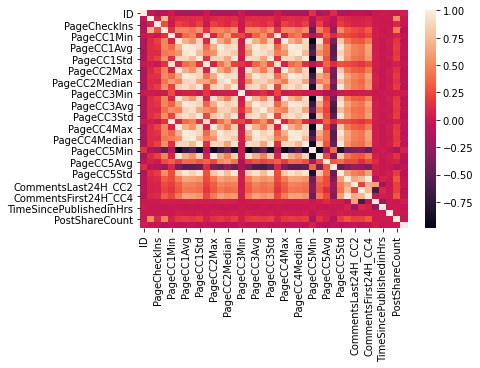

In [1316]:
DATA_TRAIN_X_CORR = DATA_TRAIN_X_NUM.corr()
sns.heatmap(DATA_TRAIN_X_CORR)
plt.show()

Several features are strongly correlated - they may be redundant, but will need to investigate their correlations to the target.

PageCategory:


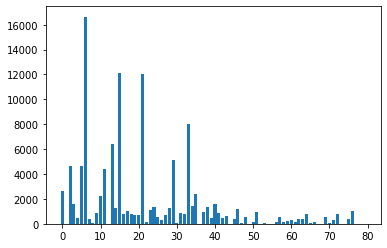

Published_:


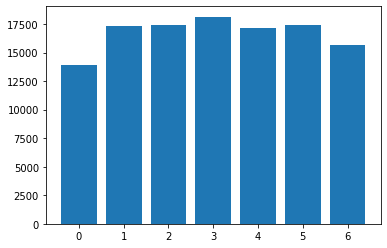

PredictOn_:


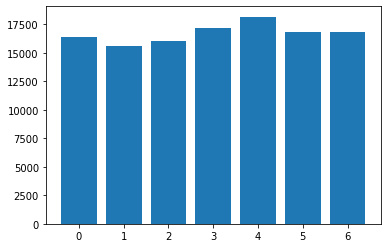

PostPromoted:


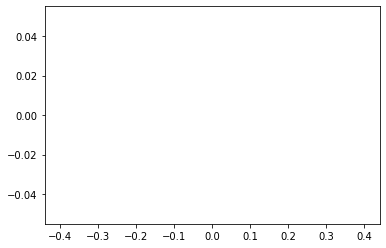

In [1317]:
nominalDataForChart = [
    {
        'name': substr,
        'data': [
            DATA_TRAIN_X_NOM[col].values.sum()
            for col in DATA_TRAIN_X_NOM
            if substr in col
        ]
    }
    for substr in G_NOM_SUBSTR
]

for chart in nominalDataForChart:
    print(chart['name'] + ':')
    plt.bar(
        x=range(len(chart['data'])),
        height=chart['data']
    )
    plt.show()

Some categories are much more common than others. Could potentially be associated with comment frequency?

There are relatively equal published posts throughout the week. Will need to check whether certain days get more comments.

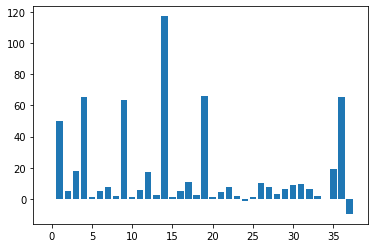

In [1318]:
DATA_TRAIN_X_SKEW = DATA_TRAIN_X_NUM.skew()
plt.bar(
    x=range(len(DATA_TRAIN_X_SKEW)),
    height=DATA_TRAIN_X_SKEW
)
plt.show()

Some columns are very skewed and will need normalization.

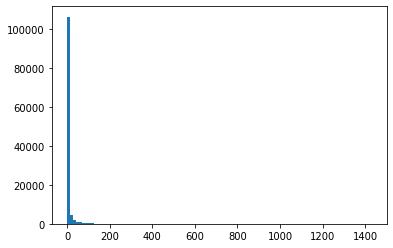

In [1319]:
plt.hist(DATA_TRAIN_Y, bins=100)
plt.show()

The target is extremely skewed - most entries have no comments. Visualize the distribution with only posts that have comments.

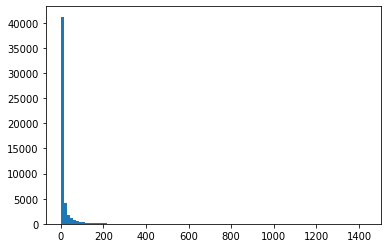

In [1320]:
hasComments = DATA_TRAIN_Y != 0
DATA_TRAIN_Y_HASCOMMENTS = DATA_TRAIN_Y[hasComments]
plt.hist(DATA_TRAIN_Y_HASCOMMENTS, bins=100)
plt.show()

Still very skewed - this is just a very skewed target variable...

### Preprocess Data

#### Handle outliers

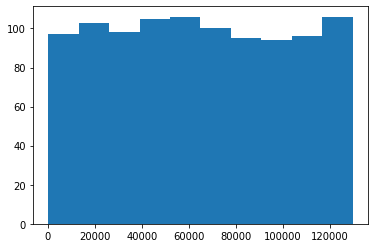

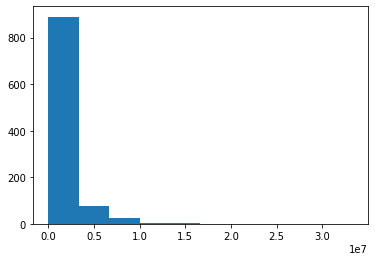

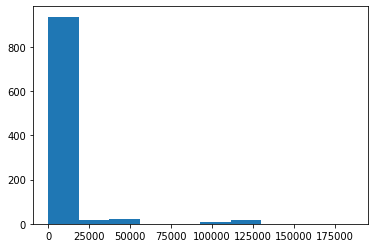

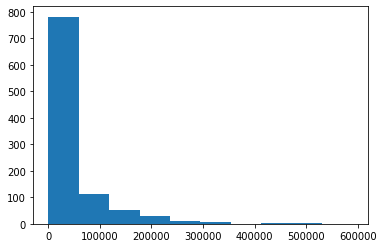

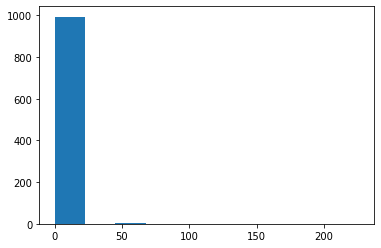

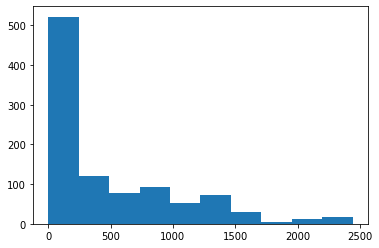

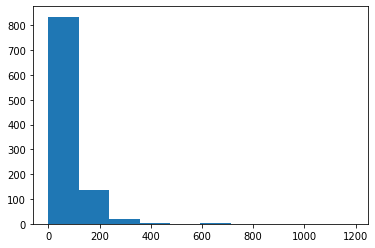

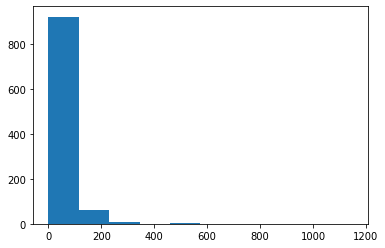

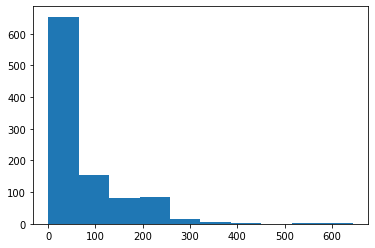

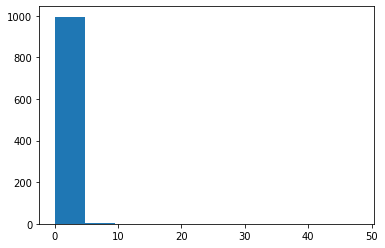

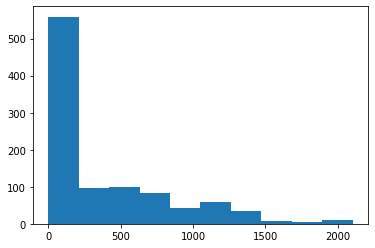

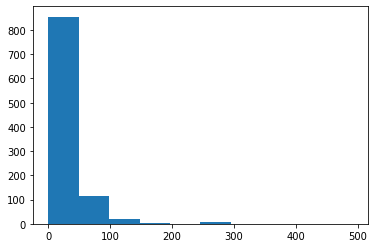

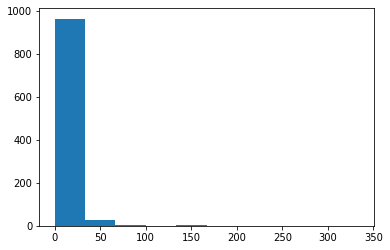

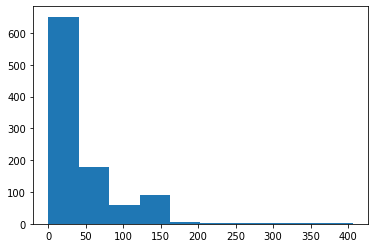

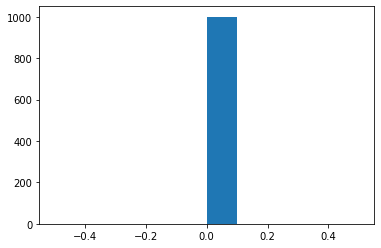

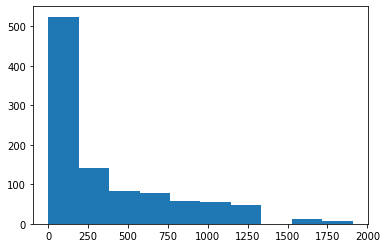

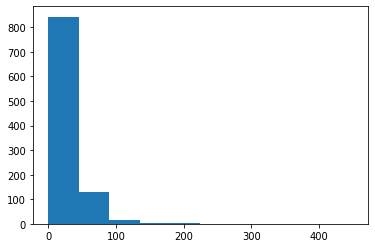

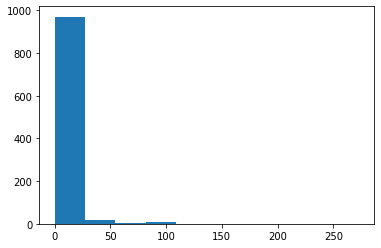

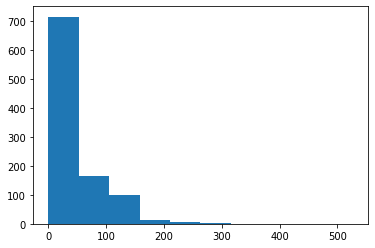

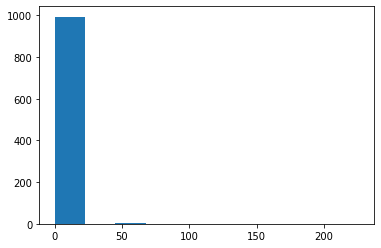

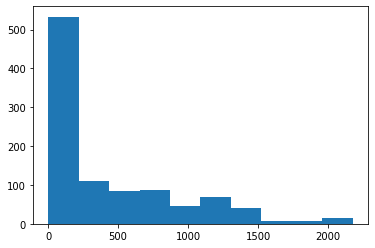

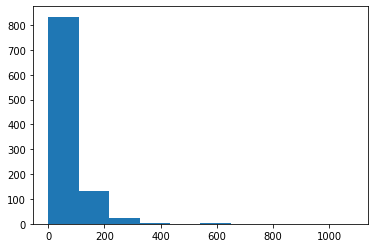

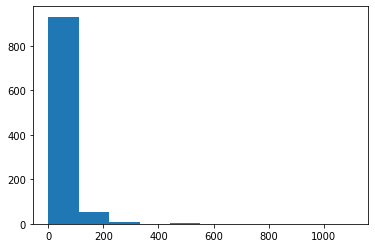

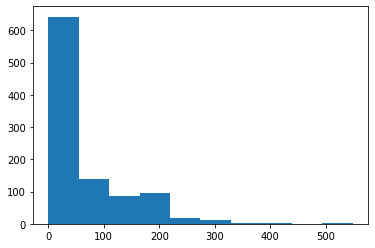

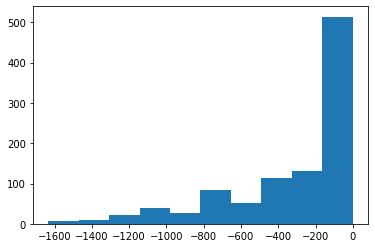

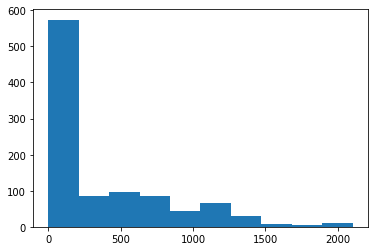

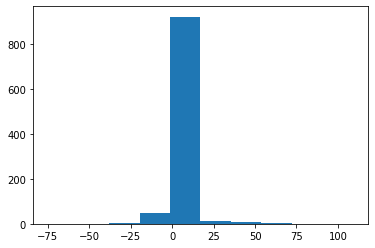

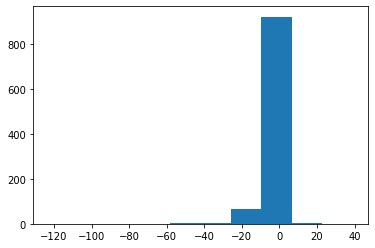

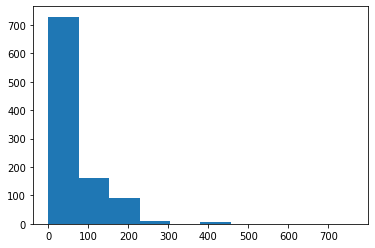

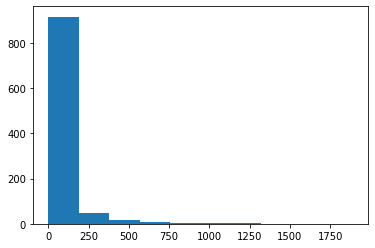

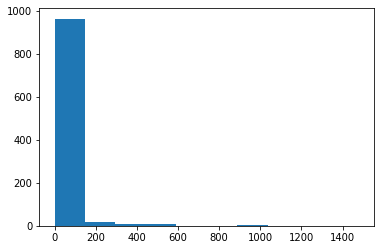

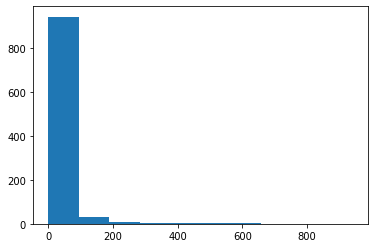

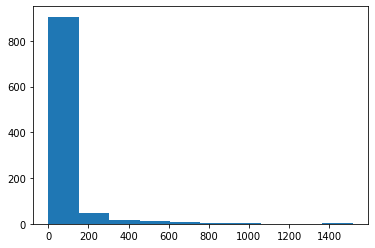

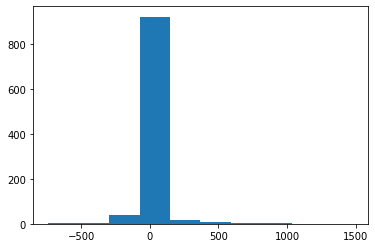

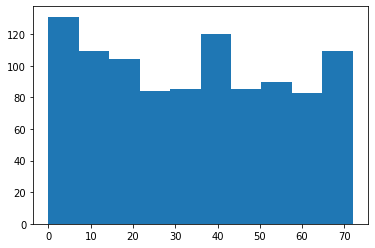

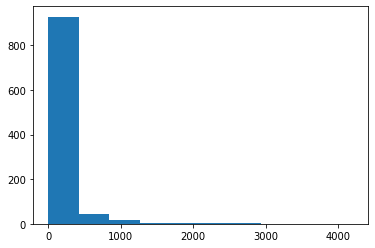

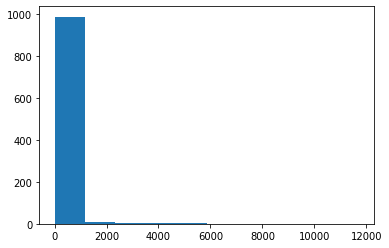

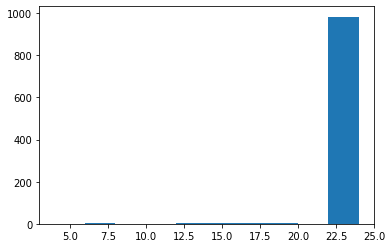

In [1321]:
DATA_TRAIN_X_CLEANED_PLOT = DATA_TRAIN_X_NUM.head(1000)

for col in DATA_TRAIN_X_CLEANED_PLOT:
    plt.hist(DATA_TRAIN_X_CLEANED_PLOT[col])
    plt.show()

Since the majority of data are positively skewed, there is likely to be a sparse subset representing outliers. We only keep data that lie in IQR of all features. For example, if a record lies within the IQR for all but one feature, it is discarded.

In [1322]:
maxFeatures = DATA_TRAIN_X_NUM.columns.size

DATA_TRAIN_X_CLEANED_OUTLIERS = DATA_TRAIN_X_NUM[
    DATA_TRAIN_X_NUM[
        (DATA_TRAIN_X_NUM < DATA_TRAIN_X_NUM.quantile(0.75)) &
        (DATA_TRAIN_X_NUM > DATA_TRAIN_X_NUM.quantile(0.25))
    ].sum(
        axis=1
    ) > maxFeatures
]

# also apply to target feature
DATA_TRAIN_Y_CLEANED_OUTLIERS = DATA_TRAIN_Y[
    DATA_TRAIN_X_NUM[
        (DATA_TRAIN_X_NUM < DATA_TRAIN_X_NUM.quantile(0.75)) &
        (DATA_TRAIN_X_NUM > DATA_TRAIN_X_NUM.quantile(0.25))
    ].sum(
        axis=1
    ) > maxFeatures
]

totalRemoved = len(DATA_TRAIN_X_NUM.index) - len(DATA_TRAIN_X_CLEANED_OUTLIERS.index)
percRemoved = round(
    totalRemoved / len(DATA_TRAIN_X_NUM.index) * 100,
    2
)

print(
    'Removed',
    totalRemoved,
    '(' + str(percRemoved) + '%)',
    'rows.'
)
print(
    len(DATA_TRAIN_X_NUM.index),
    'rows remain.'
)

Removed 5375 (4.59%) rows.
116999 rows remain.


#### Feature Engineering

In [1323]:
numCols = len(DATA_TRAIN_X_CLEANED_OUTLIERS.columns)

Add CC3 minus CC4 and CC2 minus CC4.

In [1324]:
DATA_TRAIN_X_CLEANED_OUTLIERS.insert(
    numCols,
    'CC3MinusCC4_CC6',
    DATA_TRAIN_X_CLEANED_OUTLIERS.CommentsFirst24H_CC4 - DATA_TRAIN_X_CLEANED_OUTLIERS.CommentsLast48to24H_CC3
)
DATA_TRAIN_X_CLEANED_OUTLIERS.insert(
    numCols,
    'CC2MinusCC4_CC7',
    DATA_TRAIN_X_CLEANED_OUTLIERS.CommentsFirst24H_CC4 - DATA_TRAIN_X_CLEANED_OUTLIERS.CommentsLast24H_CC2
)
# throws false positive SettingWithCopyWarning

In [1325]:
DATA_VALID_X.insert(
    numCols,
    'CC3MinusCC4_CC6',
    DATA_VALID_X.CommentsFirst24H_CC4 - DATA_VALID_X.CommentsLast48to24H_CC3
)
DATA_VALID_X.insert(
    numCols,
    'CC2MinusCC4_CC7',
    DATA_VALID_X.CommentsFirst24H_CC4 - DATA_VALID_X.CommentsLast24H_CC2
)
# throws false positive SettingWithCopyWarning

#### Feature selection

For PageCC features, only one central tendency measure and one spread measure are needed. Will keep mean and stdev for convention with a normal distribution and drop the rest.

In [1326]:
DATA_TRAIN_X_CLEANED_PAGECC = DATA_TRAIN_X_CLEANED_OUTLIERS.drop(
    [
        'Page' + CC + measure # PageCC[1-5][$$measure]
        for CC in [
            'CC' + str(i)
            for i in range(1, 6)
        ]
        for measure in [ # $$measure
            'Min',
            'Max',
            'Median'
        ]
    ],
    axis=1
)

totalRemoved = DATA_TRAIN_X_CLEANED_OUTLIERS.columns.size - DATA_TRAIN_X_CLEANED_PAGECC.columns.size
percRemoved = round(
    totalRemoved / DATA_TRAIN_X.columns.size * 100,
    2
)

print(
    'Removed',
    totalRemoved,
    '(' + str(percRemoved) + '%)',
    'columns.'
)
print(
    DATA_TRAIN_X_CLEANED_PAGECC.columns.size,
    'columns remain.'
)

Removed 15 (11.28%) columns.
25 columns remain.


Remove columns with low (<20%) variance.

In [1327]:
varThreshold = VarianceThreshold(threshold=0.8).fit(DATA_TRAIN_X_CLEANED_PAGECC)
DATA_TRAIN_X_CLEANED_VAR = DATA_TRAIN_X_CLEANED_PAGECC[
    DATA_TRAIN_X_CLEANED_PAGECC.columns[
        varThreshold.get_support(indices=True)
    ]
]

totalRemoved = DATA_TRAIN_X_CLEANED_PAGECC.columns.size - DATA_TRAIN_X_CLEANED_VAR.columns.size
percRemoved = round(
    totalRemoved / DATA_TRAIN_X.columns.size *100,
    2
)

print(
    'Removed',
    totalRemoved,
    '(' + str(percRemoved) + '%)',
    'numerical columns.'
)
print(
    DATA_TRAIN_X_CLEANED_VAR.columns.size,
    'numerical columns remain.'
)

varThreshold = VarianceThreshold(threshold=0).fit(DATA_TRAIN_X_NOM)
DATA_TRAIN_X_CLEANED_VAR_NOM = DATA_TRAIN_X_NOM[
    DATA_TRAIN_X_NOM.columns[
        varThreshold.get_support(indices=True)
    ]
]

totalRemoved = DATA_TRAIN_X_NOM.columns.size - DATA_TRAIN_X_CLEANED_VAR_NOM.columns.size
percRemoved = round(
    totalRemoved / DATA_TRAIN_X.columns.size * 100,
    2
)

print(
    'Removed',
    totalRemoved,
    '(' + str(percRemoved) + '%)',
    'nominal columns.'
)
print(
    DATA_TRAIN_X_CLEANED_VAR_NOM.columns.size,
    'nominal columns remain.'
)

Removed 0 (0.0%) numerical columns.
25 numerical columns remain.
Removed 10 (7.52%) nominal columns.
85 nominal columns remain.


Remove statistically insignificant categorical columns with ANOVA.

In [1328]:
significance = 0.01
selectBest = SelectKBest(
    f_classif,
    k=85
).fit(DATA_TRAIN_X_CLEANED_VAR_NOM, DATA_TRAIN_Y)
DATA_TRAIN_X_CLEANED_ANOVA = DATA_TRAIN_X_CLEANED_VAR_NOM[
    DATA_TRAIN_X_CLEANED_VAR_NOM.columns[selectBest.pvalues_ < significance]
]

totalRemoved = DATA_TRAIN_X_CLEANED_VAR_NOM.columns.size - DATA_TRAIN_X_CLEANED_ANOVA.columns.size
percRemoved = round(
    totalRemoved / DATA_TRAIN_X.columns.size * 100,
    2
)

print(
    'Removed',
    totalRemoved,
    '(' + str(percRemoved) + '%)',
    'nominal columns.'
)
print(
    DATA_TRAIN_X_CLEANED_ANOVA.columns.size,
    'nominal columns remain.'
)

Removed 66 (49.62%) nominal columns.
19 nominal columns remain.


Drop columns that are not correlated (<5%) with the target.

In [1329]:
correl = DATA_TRAIN_X_CLEANED_VAR.corrwith(
    DATA_TRAIN_Y,
    axis=0,
    method='pearson'
)
DATA_TRAIN_X_CLEANED_CORREL = DATA_TRAIN_X_CLEANED_VAR.drop(
    correl.index[abs(correl) < 0.05],
    axis=1
)

totalRemoved = DATA_TRAIN_X_CLEANED_VAR.columns.size - DATA_TRAIN_X_CLEANED_CORREL.columns.size
percRemoved = round(
    totalRemoved / DATA_TRAIN_X.columns.size * 100,
    2
)

print(
    'Removed',
    totalRemoved,
    '(' + str(percRemoved) + '%)',
    'columns.'
)
print(
    DATA_TRAIN_X_CLEANED_CORREL.columns.size,
    'columns remain.'
)

Removed 4 (3.01%) columns.
21 columns remain.


In [1330]:
selectedFeatures = DATA_TRAIN_X_CLEANED_CORREL.columns
DATA_TRAIN_X_CLEANED_CORREL.columns

Index(['PageLikes', 'DailyInterest', 'PageCC1Avg', 'PageCC1Std', 'PageCC2Avg',
       'PageCC2Std', 'PageCC3Avg', 'PageCC3Std', 'PageCC4Avg', 'PageCC4Std',
       'PageCC5Avg', 'PageCC5Std', 'TotalComments_CC1', 'CommentsLast24H_CC2',
       'CommentsLast48to24H_CC3', 'CommentsFirst24H_CC4', 'CC2MinusCC3_CC5',
       'TimeSincePublishedinHrs', 'PostShareCount', 'CC2MinusCC4_CC7',
       'CC3MinusCC4_CC6'],
      dtype='object')

#### Normalization

Normalize skewed columns.

In [1331]:
skewTransforms = []

def transformSkew(col, undo=False):
    if undo:
        currentTransform = [
            transform for transform in skewTransforms
            if transform['Series'] == col.name
        ][0]
        for _ in range(currentTransform['exp']):
            col = np.log(col + 1) * 100000000
        for _ in range(currentTransform['log']):
            col = np.exp(col / 100000000) - 1
    else:
        skew = col.skew()
        currentTransform = {
            'Series': col.name,
            'exp': 0,
            'log': 0
        }
        while skew > 1.5 or skew < -1.5:
            if skew > 1.5:
                col = np.exp(col / 100000000) - 1 # prevent inf
                currentTransform['exp'] += 1
            elif skew < -1.5:
                col = np.log(col + 1) * 100000000
                currentTransform['log'] += 1
            skew = col.skew()
        skewTransforms.append(currentTransform)
    return(col)

In [1332]:
DATA_TRAIN_X_CLEANED_SKEW = DATA_TRAIN_X_CLEANED_CORREL.apply(
    transformSkew,
    axis=0
)

In [1333]:
DATA_TRAIN_X_CLEANED_SKEW.describe()

PageLikes  DailyInterest    PageCC1Avg    PageCC1Std    PageCC2Avg  \
count  1.116240e+05   1.116240e+05  1.116240e+05  1.116240e+05  1.116240e+05   
mean   2.201791e-10   3.654362e-12  5.209552e-15  6.452765e-15  2.035841e-15   
std    1.096548e-08   8.111639e-12  8.502532e-15  8.156258e-15  3.460717e-15   
min    5.995204e-15   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    4.788392e-12   7.016610e-14  4.440892e-16  6.661338e-16  2.220446e-16   
50%    2.536704e-11   4.467537e-13  1.998401e-15  2.886580e-15  6.661338e-16   
75%    8.951417e-11   3.700373e-12  6.883383e-15  9.992007e-15  2.664535e-15   
max    1.292849e-06   4.039222e-10  2.031708e-13  6.439294e-14  9.725554e-14   

         PageCC2Std    PageCC3Avg    PageCC3Std    PageCC4Avg    PageCC4Std  \
count  1.116240e+05  1.116240e+05  1.116240e+05  1.116240e+05  1.116240e+05   
mean   3.802936e-15  1.856246e-15  3.778241e-15  4.885964e-15  5.968929e-15   
std    4.937106e-15  3.115498e-15  5.103879e-15  7.921141e-15  7.546033e-15   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    4.440892e-16  2.220446e-16  4.440892e-16  4.440892e-16  6.661338e-16   
50%    1.554312e-15  6.661338e-16  1.554312e-15  1.776357e-15  2.442491e-15   
75%    5.329071e-15  2.442491e-15  5.329071e-15  6.661338e-15  9.103829e-15   
max    6.838974e-14  6.616929e-14  8.015810e-14  1.869616e-13  5.662137e-14   

       ...    PageCC5Std  TotalComments_CC1  CommentsLast24H_CC2  \
count  ...  1.116240e+05       1.116240e+05         1.116240e+05   
mean   ...  5.225677e-15       5.170060e-15         1.974107e-15   
std    ...  7.112021e-15       1.339002e-14         6.947340e-15   
min    ...  0.000000e+00       0.000000e+00         0.000000e+00   
25%    ...  6.661338e-16       2.220446e-16         0.000000e+00   
50%    ...  1.998401e-15       1.110223e-15         2.220446e-16   
75%    ...  7.549517e-15       3.996803e-15         1.110223e-15   
max    ...  1.385558e-13       2.495781e-13         2.102762e-13   

       CommentsLast48to24H_CC3  CommentsFirst24H_CC4  CC2MinusCC3_CC5  \
count             1.116240e+05          1.116240e+05    111624.000000   
mean              1.911081e-15          4.845845e-15         0.672526   
std               7.284077e-15          1.240797e-14        88.616422   
min               0.000000e+00          0.000000e+00     -1634.000000   
25%               0.000000e+00          2.220446e-16        -5.000000   
50%               0.000000e+00          8.881784e-16         0.000000   
75%               8.881784e-16          3.774758e-15         3.000000   
max               1.962874e-13          2.184919e-13      2102.000000   

       TimeSincePublishedinHrs  PostShareCount  CC2MinusCC4_CC7  \
count            111624.000000    1.116240e+05     1.116240e+05   
mean                 35.568166    9.690927e-15     2.863409e-15   
std                  20.848594    4.669007e-14     9.288767e-15   
min                   0.000000    0.000000e+00    -5.917489e-14   
25%                  18.000000    2.220446e-16     0.000000e+00   
50%                  36.000000    1.332268e-15     0.000000e+00   
75%                  53.000000    5.329071e-15     1.554312e-15   
max                  72.000000    7.765566e-12     2.136069e-13   

       CC3MinusCC4_CC6  
count     1.116240e+05  
mean      2.926942e-15  
std       8.540472e-15  
min      -5.906386e-14  
25%       0.000000e+00  
50%       4.440892e-16  
75%       1.998401e-15  
max       2.102762e-13  

[8 rows x 21 columns]

Normalize target variable

In [1334]:
DATA_TRAIN_Y_CLEANED_SKEW = transformSkew(DATA_TRAIN_Y_CLEANED_OUTLIERS)

In [1335]:
DATA_TRAIN_X_FINAL = DATA_TRAIN_X_CLEANED_SKEW.join(DATA_TRAIN_X_CLEANED_ANOVA)
DATA_TRAIN_Y_FINAL = DATA_TRAIN_Y_CLEANED_SKEW

#### Clean validation set

In [1336]:
def reapplyTransformSkew(col):
    if any(obj['Series'] == col.name for obj in skewTransforms):
        skewTransform = [
            obj for obj in skewTransforms
            if obj['Series'] == col.name
        ]
        transformedCol = col
        for i in range(skewTransform[0]['log']):
            transformedCol = np.log(transformedCol + 1) * 100000000
        for i in range(skewTransform[0]['exp']):
            transformedCol = np.exp(transformedCol / 100000000) - 1
        return(transformedCol)
    return(col)

In [1337]:
DATA_VALID_X_TRANSFORMED = DATA_VALID_X[DATA_TRAIN_X_FINAL.columns].apply(reapplyTransformSkew)
DATA_VALID_Y_TRANSFORMED = reapplyTransformSkew(DATA_VALID_Y)

### Baseline Model

Full models should outperform these baselines and will be discarded if they don't.

In [1338]:
DATA_TRAIN_X_FINAL.shape

(111624, 40)

In [1339]:
def score(truth, pred, trainOrTest='Test'):
    error = round(mean_squared_error(truth, pred, squared=False), 2)
    print(trainOrTest, 'Error:', error)

def baselinePipeline(model):
    model.fit(DATA_TRAIN_X_FINAL, DATA_TRAIN_Y_FINAL)
    train_pred = pd.Series(
        model.predict(DATA_TRAIN_X_FINAL),
        name='CommentsNumber',
        index=DATA_TRAIN_X_FINAL.index
    )
    pred = pd.Series(
        model.predict(DATA_VALID_X_TRANSFORMED),
        name='CommentsNumber',
        index=DATA_VALID_X_TRANSFORMED.index
    )
    normalizedTrainPred = transformSkew(train_pred, undo=True)
    score(
        DATA_TRAIN_Y_CLEANED_OUTLIERS,
        normalizedTrainPred,
        'Train'
    )
    plt.scatter(DATA_TRAIN_Y_CLEANED_OUTLIERS, normalizedTrainPred)
    plt.show()
    normalizedTestPred = transformSkew(pred, undo=True)
    score(
        DATA_VALID_Y,
        normalizedTestPred
    )
    plt.scatter(DATA_VALID_Y, normalizedTestPred)
    plt.show()
    return(model)

#### Multiple linear regression

Train Error: 28.23


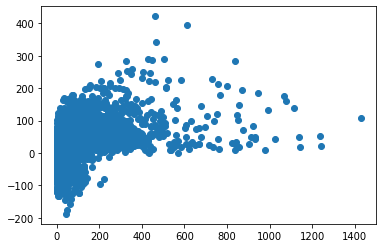

Test Error: 31.55


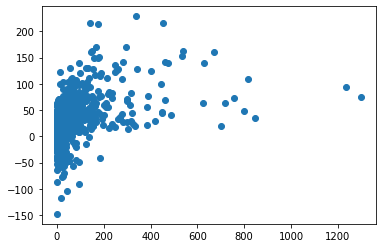

In [1340]:
reg = baselinePipeline(LinearRegression(
    n_jobs=-1
))

#### KNN regression

Train Error: 1.19


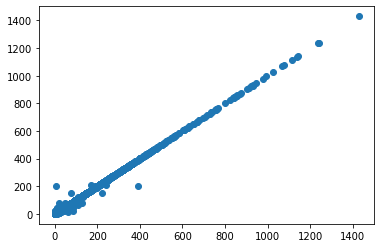

Test Error: 26.32


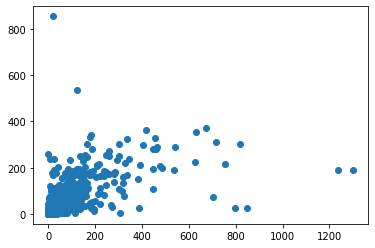

In [1341]:
neigh = baselinePipeline(KNeighborsRegressor(
    n_neighbors=20,
    p=1,
    metric='minkowski',
    weights='distance',
    n_jobs=-1
))

#### Decision tree regression

Train Error: 11.24


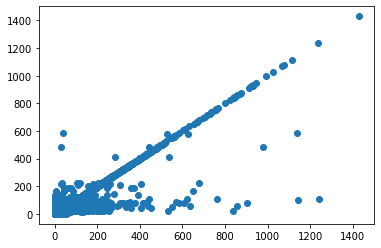

Test Error: 27.42


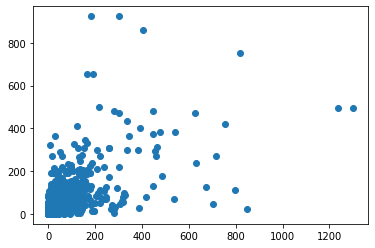

In [1342]:
dt = baselinePipeline(DecisionTreeRegressor(
    random_state=G_RANDOM_SEED
))

### Production Models

Production models will be tuned using 10-fold CV. Each fold will follow the above pipeline and apply the steps to both the train and validation sets for the fold so as to prevent leakage, except for feature selection. Since it will be impossible to guarantee that the above feature selection pipeline yields the same features for every fold, the 10-fold CV will use the same features selected using the above pipeline, instead of selecting new features for each individual fold.

In [1343]:
def tuningPipeline(
    model,
    verbose=False
):
    # Define starting data for pipeline
    X = DATA_TRAIN_AND_VALID_X_ENCODED
    y = DATA_TRAIN_AND_VALID_Y
    
    # Set up CV
    kf = KFold(
        n_splits=10,
        shuffle=True,
        random_state=G_RANDOM_SEED
    )
    foldNum = 0
    returnDict = {
        'train': [],
        'valid': [],
        'models': []
    }
    
    # Do CV
    for train_index, test_index in kf.split(X):
        foldNum += 1
        if verbose:
            print('Fold #' + str(foldNum))
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Split numerical and one-hot-encoded features
        X_NOM = X_train[[
            col for col in X_train.columns
            if any(
                substring in col
                for substring in G_NOM_SUBSTR
            )
        ]]
        X_NUM = X_train[[
            col for col in X_train.columns
            if not any(
                substring in col
                for substring in G_NOM_SUBSTR
            )
        ]]

        # The below pipeline steps are copied from above

        # Feature selection

        # Handle outliers
        maxFeatures = X_NUM.columns.size

        X_NUM_CLEANED_OUTLIERS = X_NUM[
            X_NUM[
                (X_NUM < X_NUM.quantile(0.75)) &
                (X_NUM > X_NUM.quantile(0.25))
            ].sum(
                axis=1
            ) > maxFeatures
        ]

        # also apply to target feature
        y_CLEANED_OUTLIERS = y_train[
            X_NUM[
                (X_NUM < X_NUM.quantile(0.75)) &
                (X_NUM > X_NUM.quantile(0.25))
            ].sum(
                axis=1
            ) > maxFeatures
        ]

        # Feature engineering
        X_NUM_CLEANED_OUTLIERS.insert(
            numCols,
            'CC3MinusCC4_CC6',
            X_NUM_CLEANED_OUTLIERS.CommentsFirst24H_CC4 - X_NUM_CLEANED_OUTLIERS.CommentsLast48to24H_CC3
        )
        X_NUM_CLEANED_OUTLIERS.insert(
            numCols,
            'CC2MinusCC4_CC7',
            X_NUM_CLEANED_OUTLIERS.CommentsFirst24H_CC4 - X_NUM_CLEANED_OUTLIERS.CommentsLast24H_CC2
        )

        X_test.insert(
            numCols,
            'CC3MinusCC4_CC6',
            X_test.CommentsFirst24H_CC4 - X_test.CommentsLast48to24H_CC3
        )
        X_test.insert(
            numCols,
            'CC2MinusCC4_CC7',
            X_test.CommentsFirst24H_CC4 - X_test.CommentsLast24H_CC2
        )
        # throws false positive SettingWithCopyWarning

        # Feature selection
        # According to above note in markdown cell, uses same columns instead of applying the pipeline again
        # This is to guarantee the same features are used in all folds
        selectedNums = [col for col in selectedFeatures if col in X_NUM_CLEANED_OUTLIERS]
        selectedNoms = [col for col in selectedFeatures if col in X_NOM]
        X_NUM_SELECTED = X_NUM_CLEANED_OUTLIERS[selectedNums]
        X_NOM_SELECTED = X_NUM_CLEANED_OUTLIERS[selectedNoms]
        X_test_SELECTED = X_test[selectedFeatures]
        
        # Normalize data
        skewTransformsCV = []
        def transformSkewCV(col, undo=False):
            if undo:
                currentTransform = [
                    transform for transform in skewTransformsCV
                    if transform['Series'] == col.name
                ][0]
                for _ in range(currentTransform['exp']):
                    col = np.log(col + 1) * 100000000
                for _ in range(currentTransform['log']):
                    col = np.exp(col / 100000000) - 1
            else:
                skew = col.skew()
                currentTransform = {
                    'Series': col.name,
                    'exp': 0,
                    'log': 0
                }
                while skew > 1.5 or skew < -1.5:
                    if skew > 1.5:
                        col = np.exp(col / 100000000) - 1 # prevent inf
                        currentTransform['exp'] += 1
                    elif skew < -1.5:
                        col = np.log(col + 1) * 100000000
                        currentTransform['log'] += 1
                    skew = col.skew()
                skewTransformsCV.append(currentTransform)
            return(col)
        
        X_NUM_SKEW = X_NUM_SELECTED.apply(
            transformSkewCV,
            axis=0
        )
        y_CLEANED_SKEW = transformSkewCV(y_CLEANED_OUTLIERS)
        
        # Aggregate final train set
        X_FINAL = X_NUM_SKEW.join(X_NOM_SELECTED)
        y_FINAL = y_CLEANED_SKEW
        
        #Normalize validation set
        def reapplyTransformSkewCV(col):
            if any(obj['Series'] == col.name for obj in skewTransformsCV):
                skewTransformCV = [
                    obj for obj in skewTransformsCV
                    if obj['Series'] == col.name
                ]
                transformedCol = col
                for i in range(skewTransformCV[0]['exp']):
                    transformedCol = np.exp(transformedCol / 100000000) - 1
                for i in range(skewTransformCV[0]['log']):
                    transformedCol = np.log(transformedCol + 1) * 100000000
                return(transformedCol)
            return(col)

        def cleanCV(df, undo=False):
            dfClean = df.apply(reapplyTransformSkewCV)
            return(dfClean)
        
        X_test_TRANSFORMED = cleanCV(X_test_SELECTED[X_FINAL.columns])
        y_test_TRANSFORMED = reapplyTransformSkewCV(y_test)
        
        ## Train & run model
        def scoreCV(truth, pred, trainOrTest='Test', verbose=False):
            error = round(mean_squared_error(truth, pred, squared=False), 2)
            if verbose:
                print(trainOrTest, 'Error:', error)
            return(error)

        def CVPipeline(
            model,
            X_train,
            y_train,
            X_valid,
            y_valid,
            y_train_untransformed,
            y_valid_untransformed,
            verbose=False
        ):
            model.fit(X_train, y_train)
            train_pred = pd.Series(
                model.predict(X_train),
                name='CommentsNumber',
                index=X_train.index
            )
            pred = pd.Series(
                model.predict(X_valid),
                name='CommentsNumber',
                index=X_valid.index
            )
            normalizedTrainPred = transformSkew(train_pred, undo=True)
            errorTrain = scoreCV(
                y_train_untransformed,
                normalizedTrainPred,
                'Train',
                verbose
            )
            plt.scatter(y_train_untransformed, normalizedTrainPred)
            plt.show()
            normalizedTestPred = transformSkew(pred, undo=True)
            errorValid = scoreCV(
                y_valid_untransformed,
                normalizedTestPred,
                verbose=verbose
            )
            plt.scatter(y_valid_untransformed, normalizedTestPred)
            plt.show()
            returnDict['train'].append(errorTrain)
            returnDict['valid'].append(errorValid)
            return(model)

        trainedModel = CVPipeline(
            model,
            X_FINAL,
            y_FINAL,
            X_test_TRANSFORMED,
            y_test_TRANSFORMED,
            y_CLEANED_OUTLIERS,
            y_test,
            verbose
        )
        returnDict['models'].append(trainedModel)
    
    return(returnDict)

In [1344]:
def report(pipelineResultDict):
    trainErrors = pipelineResultDict['train']
    averageTrain = round(mean(trainErrors), 2)
    stdevTrain = round(stdev(trainErrors), 2)
    cvTrain = round(stdevTrain / averageTrain * 100, 2)
    validErrors = pipelineResultDict['valid']
    averageValid = round(mean(validErrors), 2)
    stdevValid = round(stdev(validErrors), 2)
    cvValid = round(stdevValid / averageValid * 100, 2)
    print('Training Error:', averageTrain, '(' + str(stdevTrain) + ' stdev)', '(' + str(cvTrain) + '% CV)')
    print('Validation Error:', averageValid, '(' + str(stdevValid) + ' stdev)', '(' + str(cvValid) + '% CV)')

#### Random forest regressor

As an ensemble algorithm, random forest works by averaging across to combine many, complex models. As a result, the trees can be quite deep and branch heavily without significant risk of overfitting.

Fold #1
Train Error: 15.52


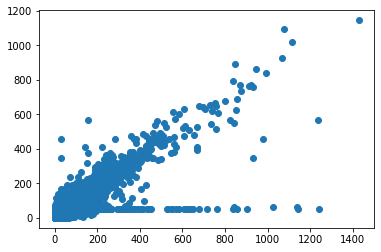

Test Error: 23.14


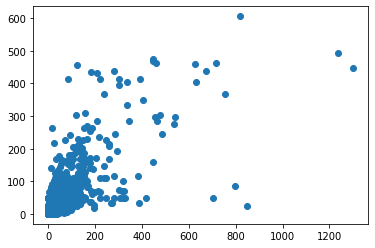

Fold #2
Train Error: 30.2


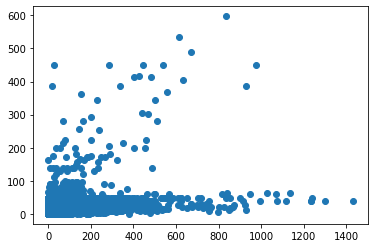

Test Error: 32.86


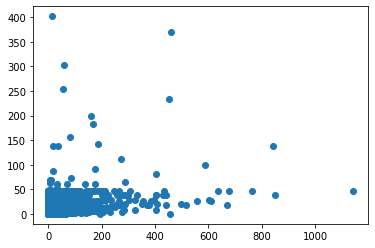

Fold #3
Train Error: 30.15


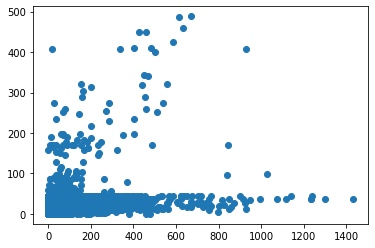

Test Error: 34.37


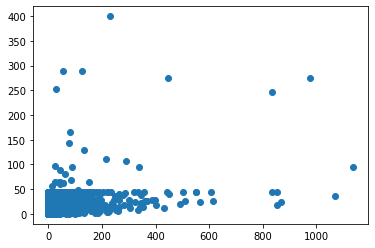

Fold #4
Train Error: 15.55


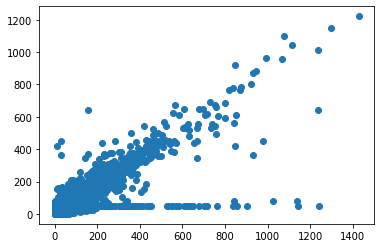

Test Error: 22.54


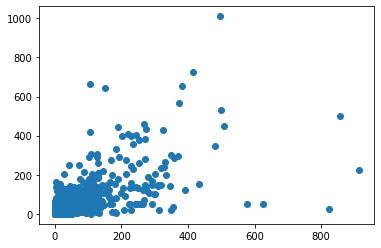

Fold #5
Train Error: 30.01


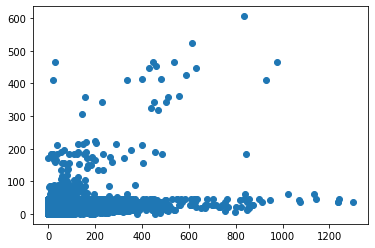

Test Error: 34.58


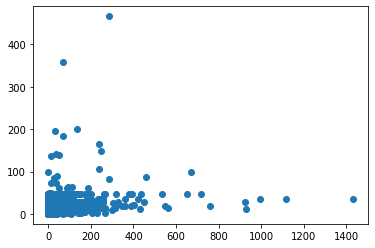

Fold #6
Train Error: 30.27


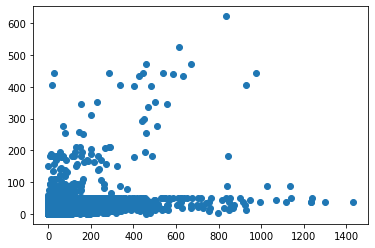

Test Error: 32.21


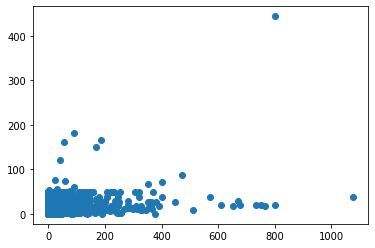

Fold #7
Train Error: 30.81


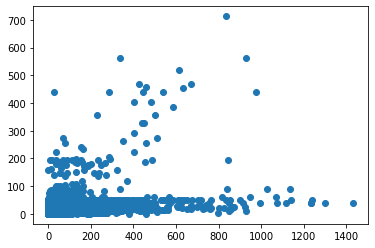

Test Error: 27.38


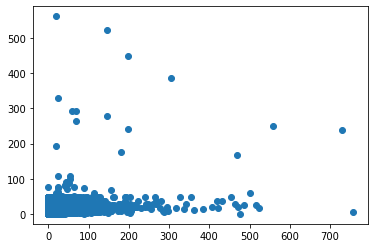

Fold #8
Train Error: 15.0


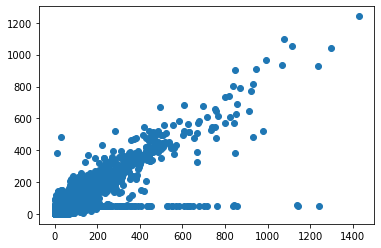

Test Error: 25.06


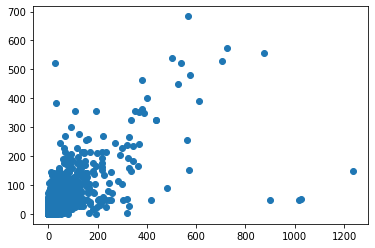

Fold #9
Train Error: 30.5


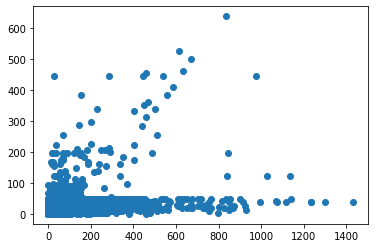

Test Error: 31.55


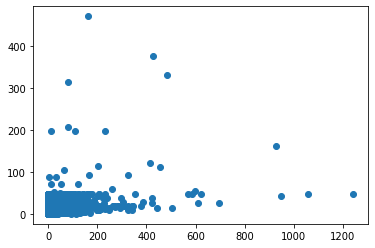

Fold #10
Train Error: 30.72


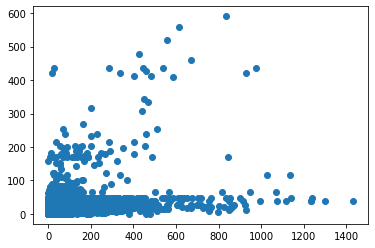

Test Error: 30.15


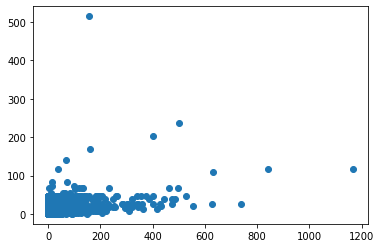

In [1345]:
regr = tuningPipeline(
    RandomForestRegressor(
        n_estimators=100,
        max_depth=800,
        random_state=G_RANDOM_SEED,
        n_jobs=-1
    ),
    verbose=True
)

In [1346]:
report(regr)

Training Error: 25.87 (7.26 stdev) (28.06% CV)
Validation Error: 29.38 (4.54 stdev) (15.45% CV)


Unfortunately, the random forest was unable to clearly improve upon baseline models. It is possible that there are subclusters within the space that the random forest is unable to generalize as well as a single, or boosted classifier, because it averages over results.

Check trees for split points and feature importances.

In [1347]:
rf_estimators = regr['models'][0].estimators_

In [1348]:
importances = []
for dt in rf_estimators:
    importances.append(dt.feature_importances_)
nd_importances = np.array(importances)
average_importances = nd_importances.mean(axis=0)
pd.DataFrame(
    average_importances,
    columns=['Average Feature Importance'],
    index=selectedFeatures
)

Average Feature Importance
PageLikes                                  0.000131
DailyInterest                              0.000000
PageCC1Avg                                 0.000000
PageCC1Std                                 0.000000
PageCC2Avg                                 0.000000
PageCC2Std                                 0.000000
PageCC3Avg                                 0.000000
PageCC3Std                                 0.000000
PageCC4Avg                                 0.000000
PageCC4Std                                 0.000000
PageCC5Avg                                 0.356054
PageCC5Std                                 0.000000
TotalComments_CC1                          0.000000
CommentsLast24H_CC2                        0.000000
CommentsLast48to24H_CC3                    0.000000
CommentsFirst24H_CC4                       0.000000
CC2MinusCC3_CC5                            0.000000
TimeSincePublishedinHrs                    0.643815
PostShareCount                             0.000000
CC2MinusCC4_CC7                            0.000000
CC3MinusCC4_CC6                            0.000000

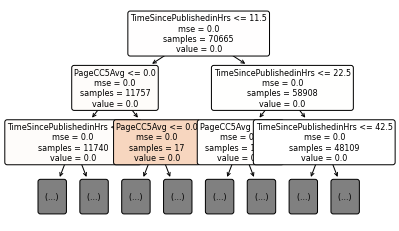

<Figure size 7200x7200 with 0 Axes>

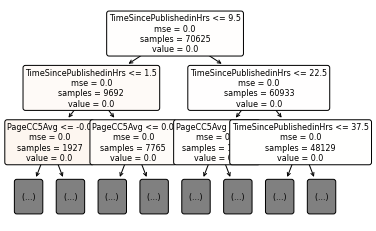

<Figure size 7200x7200 with 0 Axes>

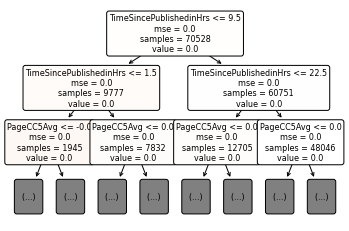

<Figure size 7200x7200 with 0 Axes>

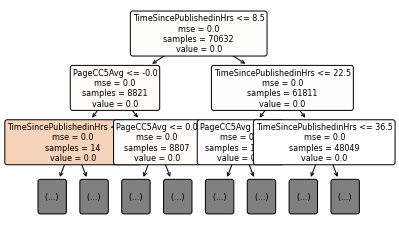

<Figure size 7200x7200 with 0 Axes>

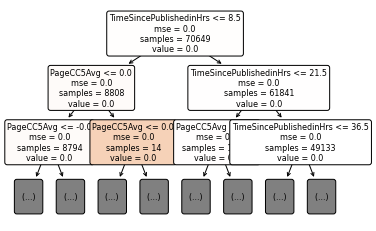

<Figure size 7200x7200 with 0 Axes>

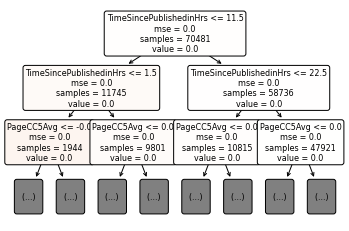

<Figure size 7200x7200 with 0 Axes>

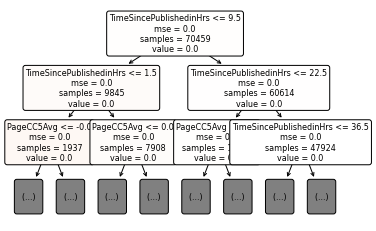

<Figure size 7200x7200 with 0 Axes>

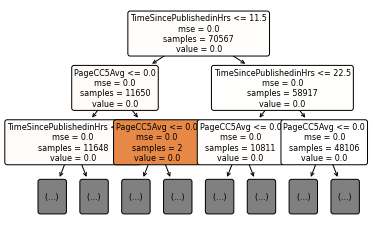

<Figure size 7200x7200 with 0 Axes>

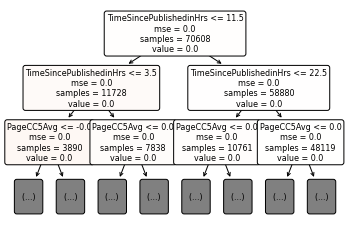

<Figure size 7200x7200 with 0 Axes>

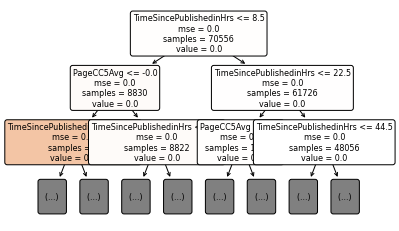

<Figure size 7200x7200 with 0 Axes>

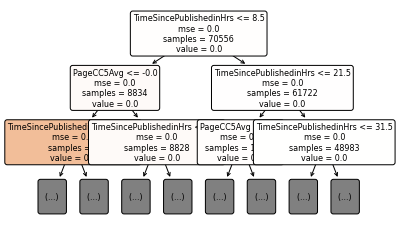

<Figure size 7200x7200 with 0 Axes>

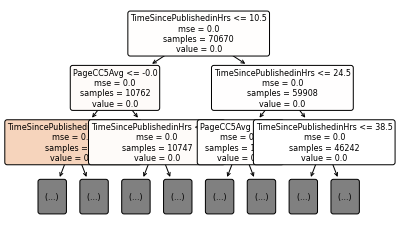

<Figure size 7200x7200 with 0 Axes>

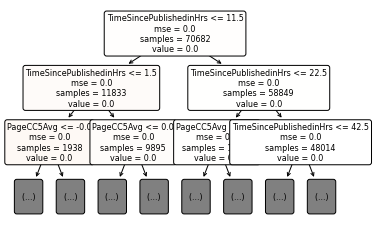

<Figure size 7200x7200 with 0 Axes>

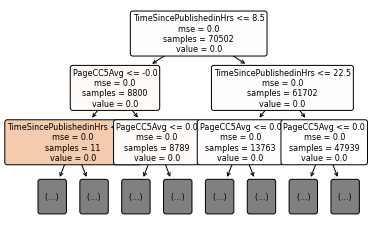

<Figure size 7200x7200 with 0 Axes>

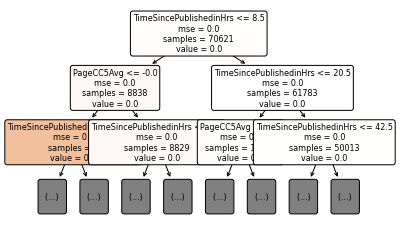

<Figure size 7200x7200 with 0 Axes>

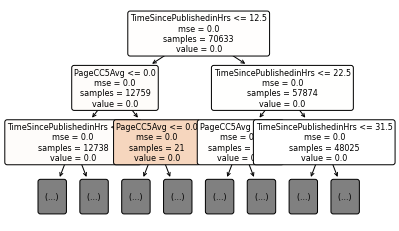

<Figure size 7200x7200 with 0 Axes>

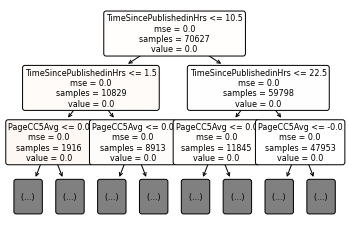

<Figure size 7200x7200 with 0 Axes>

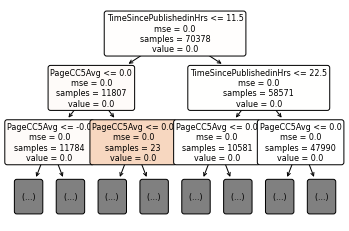

<Figure size 7200x7200 with 0 Axes>

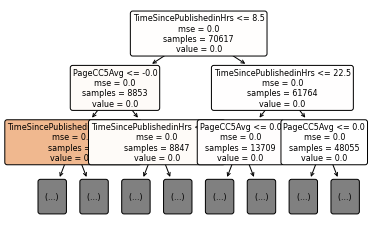

<Figure size 7200x7200 with 0 Axes>

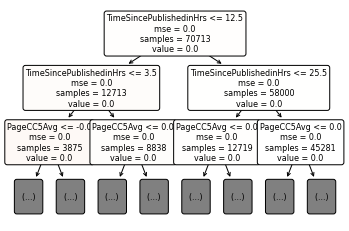

<Figure size 7200x7200 with 0 Axes>

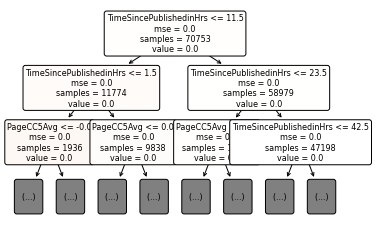

<Figure size 7200x7200 with 0 Axes>

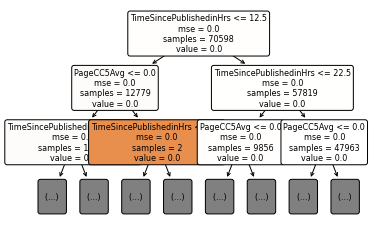

<Figure size 7200x7200 with 0 Axes>

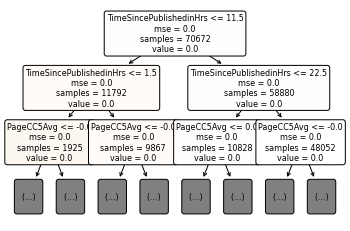

<Figure size 7200x7200 with 0 Axes>

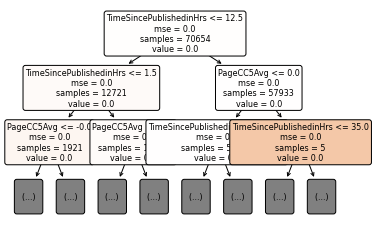

<Figure size 7200x7200 with 0 Axes>

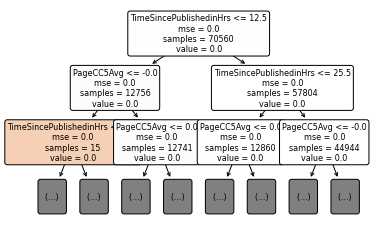

<Figure size 7200x7200 with 0 Axes>

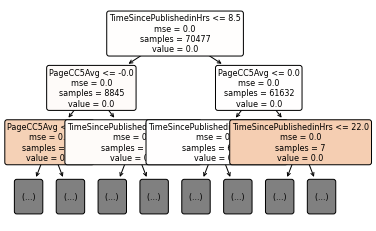

<Figure size 7200x7200 with 0 Axes>

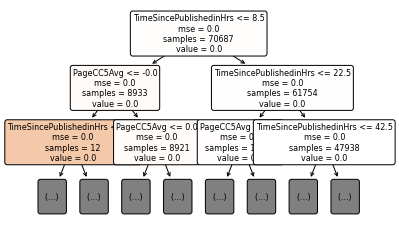

<Figure size 7200x7200 with 0 Axes>

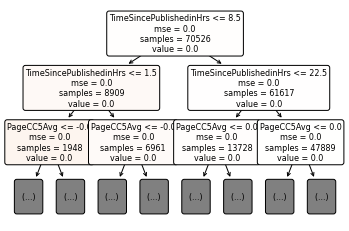

<Figure size 7200x7200 with 0 Axes>

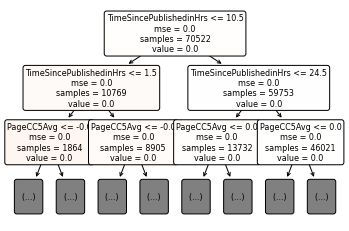

<Figure size 7200x7200 with 0 Axes>

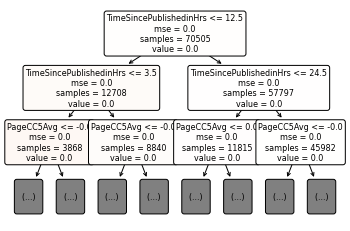

<Figure size 7200x7200 with 0 Axes>

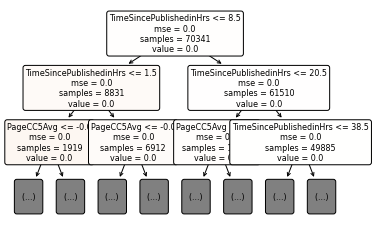

<Figure size 7200x7200 with 0 Axes>

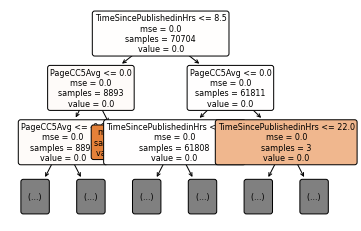

<Figure size 7200x7200 with 0 Axes>

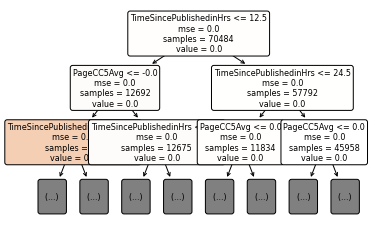

<Figure size 7200x7200 with 0 Axes>

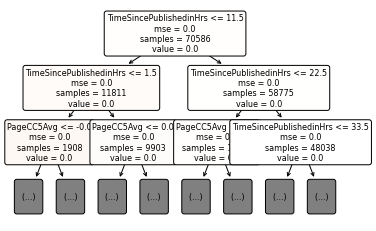

<Figure size 7200x7200 with 0 Axes>

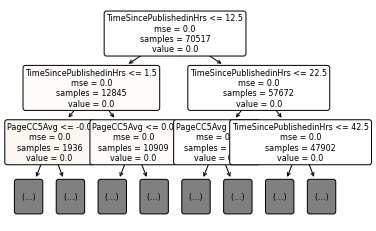

<Figure size 7200x7200 with 0 Axes>

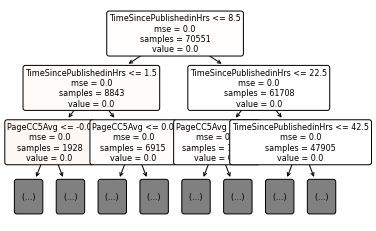

<Figure size 7200x7200 with 0 Axes>

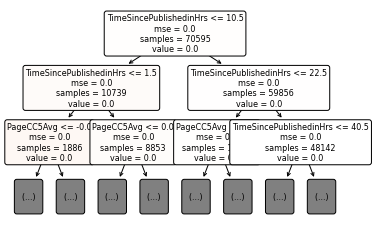

<Figure size 7200x7200 with 0 Axes>

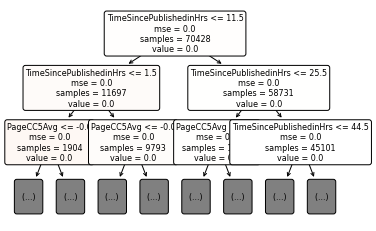

<Figure size 7200x7200 with 0 Axes>

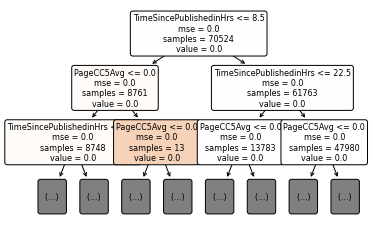

<Figure size 7200x7200 with 0 Axes>

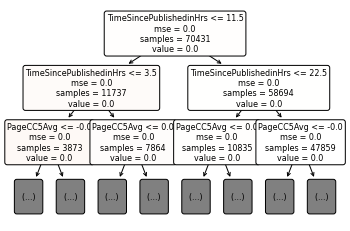

<Figure size 7200x7200 with 0 Axes>

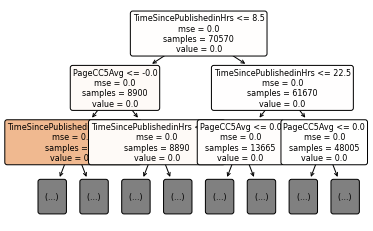

<Figure size 7200x7200 with 0 Axes>

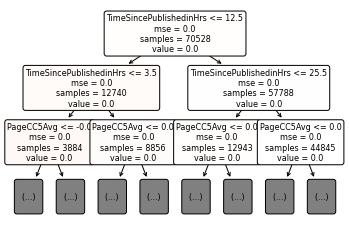

<Figure size 7200x7200 with 0 Axes>

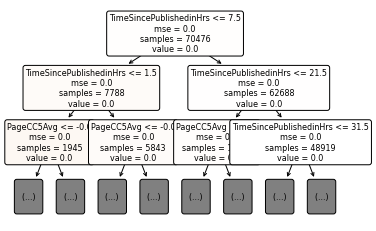

<Figure size 7200x7200 with 0 Axes>

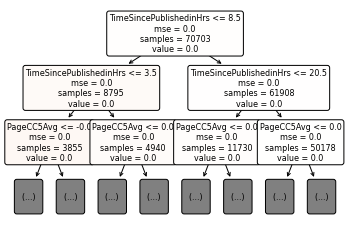

<Figure size 7200x7200 with 0 Axes>

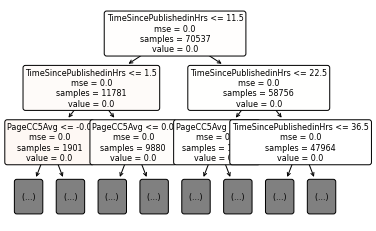

<Figure size 7200x7200 with 0 Axes>

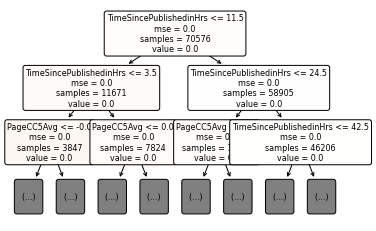

<Figure size 7200x7200 with 0 Axes>

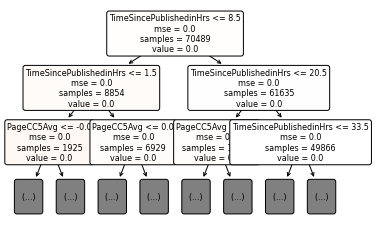

<Figure size 7200x7200 with 0 Axes>

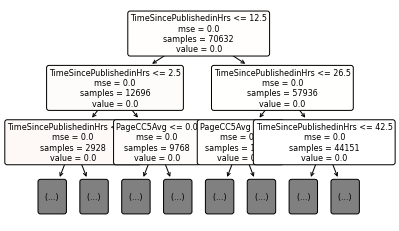

<Figure size 7200x7200 with 0 Axes>

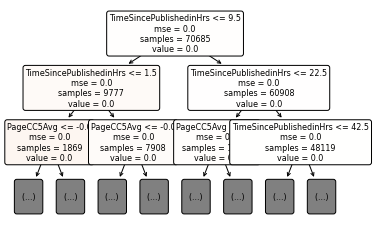

<Figure size 7200x7200 with 0 Axes>

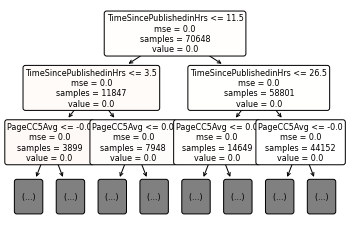

<Figure size 7200x7200 with 0 Axes>

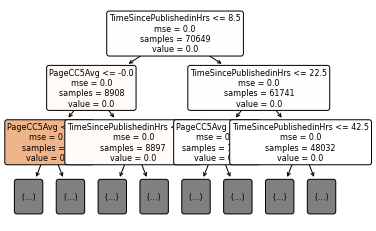

<Figure size 7200x7200 with 0 Axes>

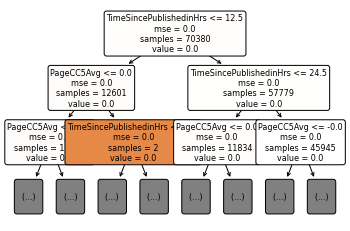

<Figure size 7200x7200 with 0 Axes>

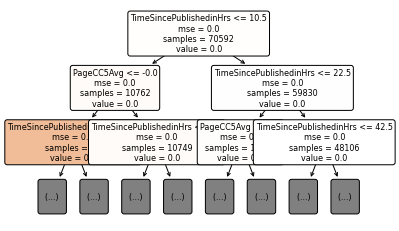

<Figure size 7200x7200 with 0 Axes>

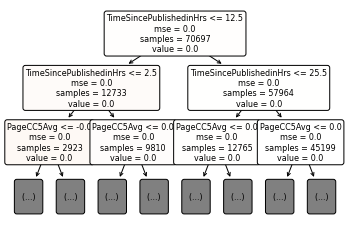

<Figure size 7200x7200 with 0 Axes>

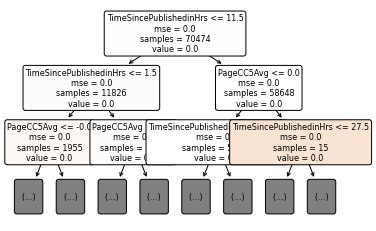

<Figure size 7200x7200 with 0 Axes>

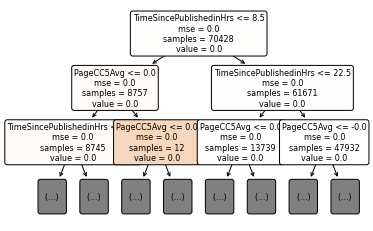

<Figure size 7200x7200 with 0 Axes>

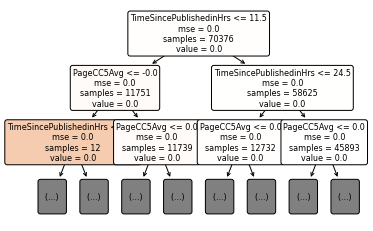

<Figure size 7200x7200 with 0 Axes>

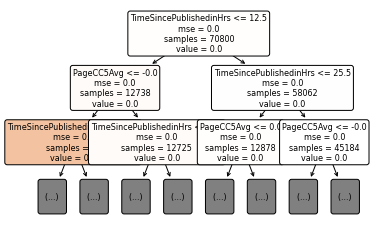

<Figure size 7200x7200 with 0 Axes>

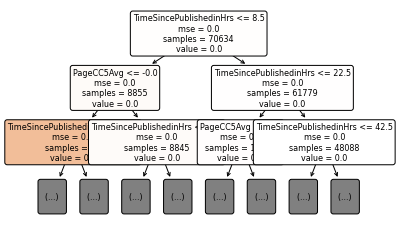

<Figure size 7200x7200 with 0 Axes>

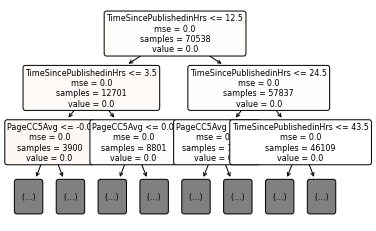

<Figure size 7200x7200 with 0 Axes>

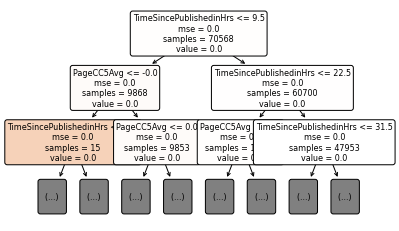

<Figure size 7200x7200 with 0 Axes>

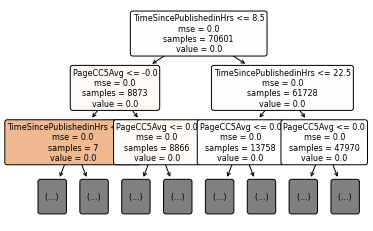

<Figure size 7200x7200 with 0 Axes>

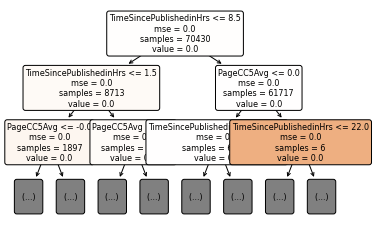

<Figure size 7200x7200 with 0 Axes>

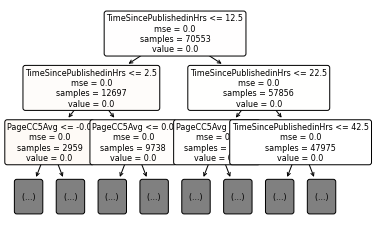

<Figure size 7200x7200 with 0 Axes>

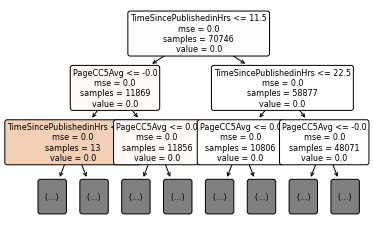

<Figure size 7200x7200 with 0 Axes>

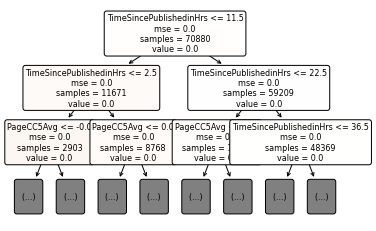

<Figure size 7200x7200 with 0 Axes>

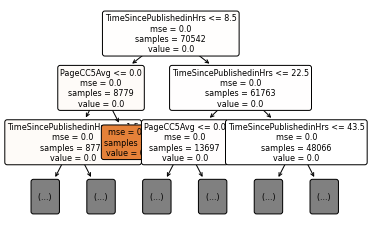

<Figure size 7200x7200 with 0 Axes>

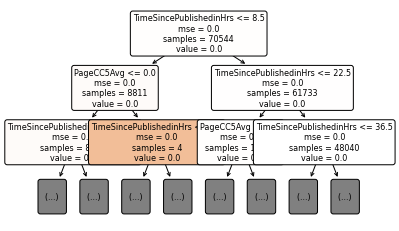

<Figure size 7200x7200 with 0 Axes>

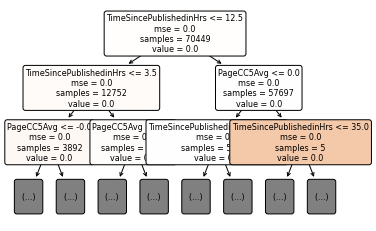

<Figure size 7200x7200 with 0 Axes>

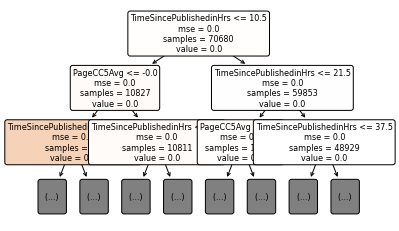

<Figure size 7200x7200 with 0 Axes>

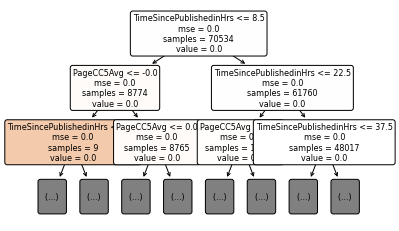

<Figure size 7200x7200 with 0 Axes>

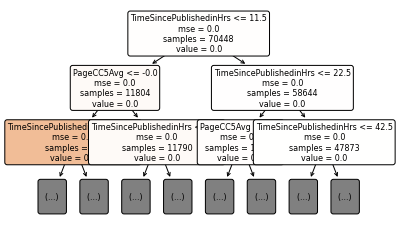

<Figure size 7200x7200 with 0 Axes>

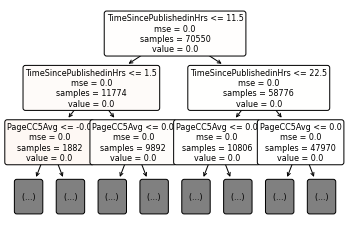

<Figure size 7200x7200 with 0 Axes>

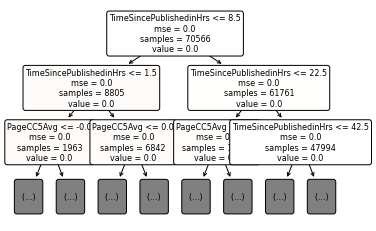

<Figure size 7200x7200 with 0 Axes>

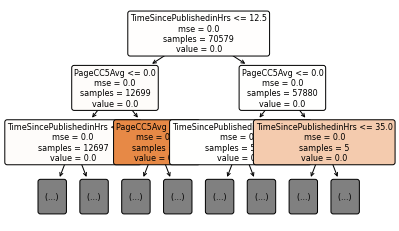

<Figure size 7200x7200 with 0 Axes>

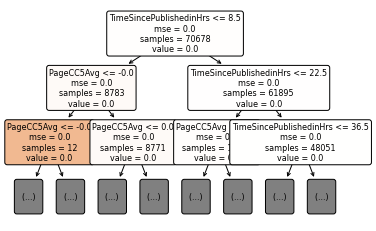

<Figure size 7200x7200 with 0 Axes>

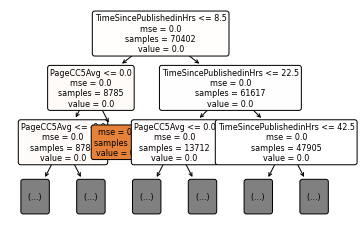

<Figure size 7200x7200 with 0 Axes>

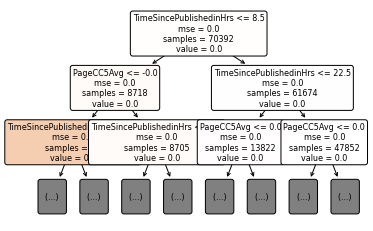

<Figure size 7200x7200 with 0 Axes>

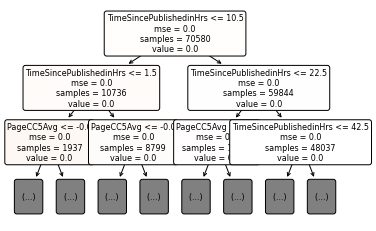

<Figure size 7200x7200 with 0 Axes>

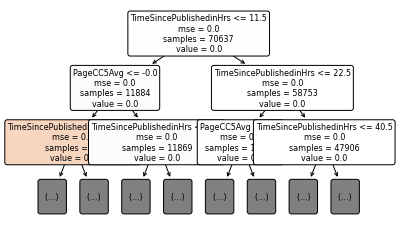

<Figure size 7200x7200 with 0 Axes>

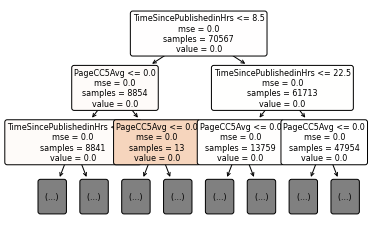

<Figure size 7200x7200 with 0 Axes>

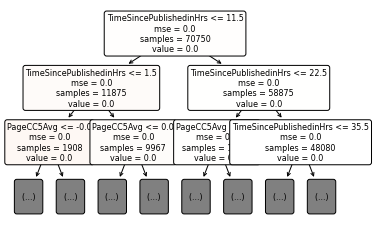

<Figure size 7200x7200 with 0 Axes>

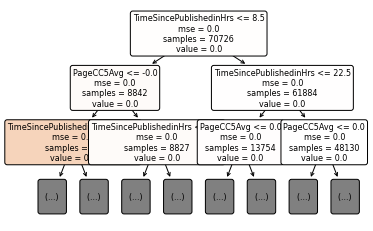

<Figure size 7200x7200 with 0 Axes>

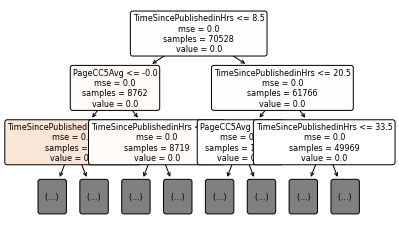

<Figure size 7200x7200 with 0 Axes>

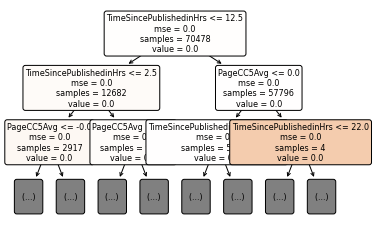

<Figure size 7200x7200 with 0 Axes>

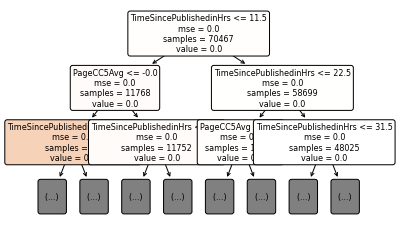

<Figure size 7200x7200 with 0 Axes>

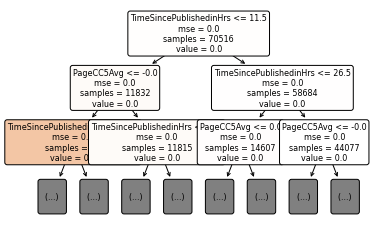

<Figure size 7200x7200 with 0 Axes>

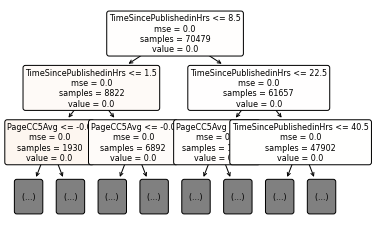

<Figure size 7200x7200 with 0 Axes>

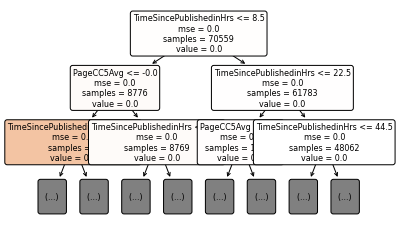

<Figure size 7200x7200 with 0 Axes>

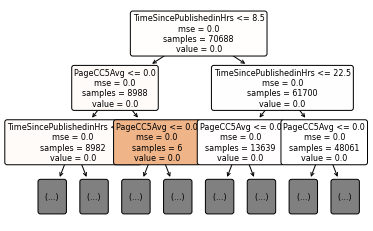

<Figure size 7200x7200 with 0 Axes>

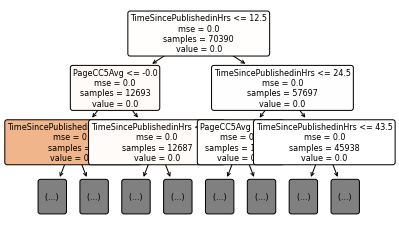

<Figure size 7200x7200 with 0 Axes>

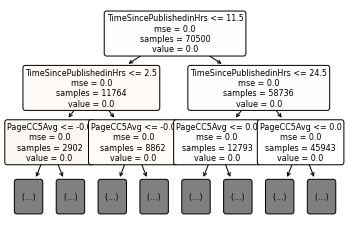

<Figure size 7200x7200 with 0 Axes>

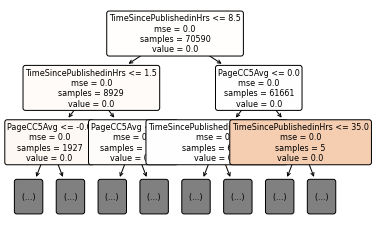

<Figure size 7200x7200 with 0 Axes>

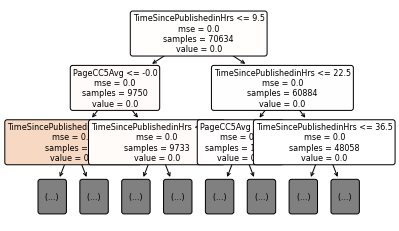

<Figure size 7200x7200 with 0 Axes>

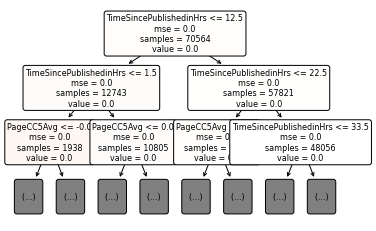

<Figure size 7200x7200 with 0 Axes>

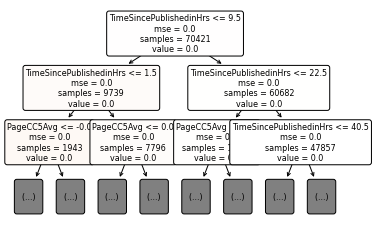

<Figure size 7200x7200 with 0 Axes>

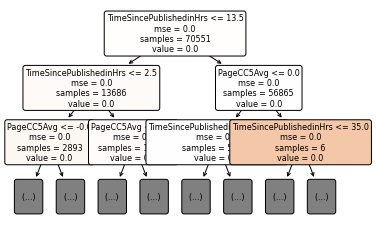

<Figure size 7200x7200 with 0 Axes>

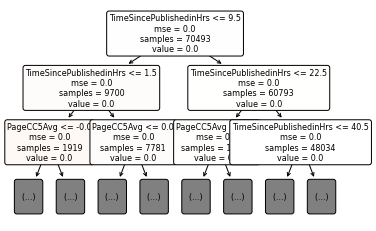

<Figure size 7200x7200 with 0 Axes>

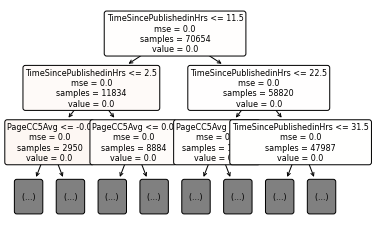

<Figure size 7200x7200 with 0 Axes>

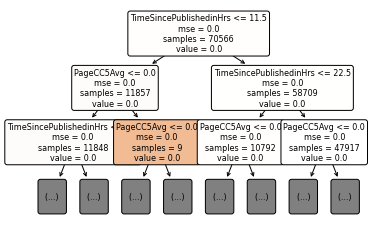

<Figure size 7200x7200 with 0 Axes>

In [1349]:
for dt in rf_estimators:
    plot_tree(
        dt,
        max_depth=2,
        feature_names=selectedFeatures,
        filled=True,
        rounded=True,
        fontsize=8
    )
    plt.figure(
        figsize=(100, 100)
    )
    plt.show()

Clearly, the most important two features are the amount of time since the post was published and the average number of comments fromt he last 24 hours. Page likes was also a factor, but was likely more important in differentiating within classes of "high traffic" and "low traffic" posts, since splits for the feature did not appear until further down the tree.

These results might make sense intuitively because the longer a post is live for, the more likely it is to pick up momentum and accrue comments and the more popular a post has been in recent hours, the more likely it is to get more comments from sharing and showing up in news feeds.

Fold #1
Train Error: 1.62


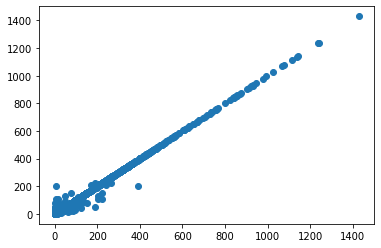

Test Error: 26.54


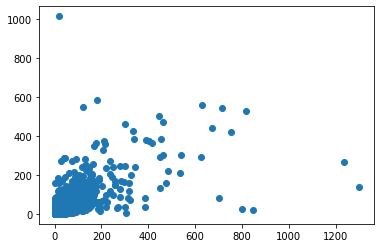

Fold #2
Train Error: 1.59


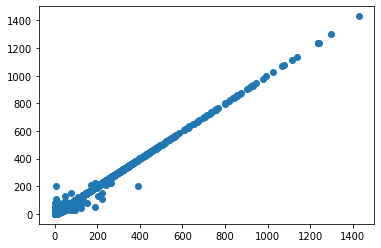

Test Error: 26.15


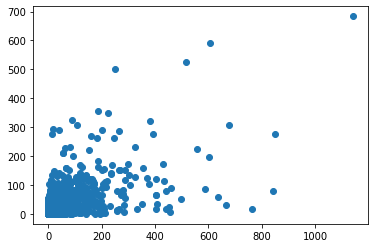

Fold #3
Train Error: 1.55


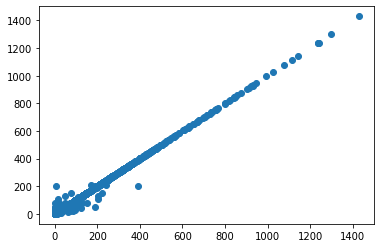

Test Error: 28.72


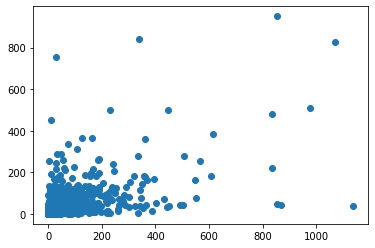

Fold #4
Train Error: 1.36


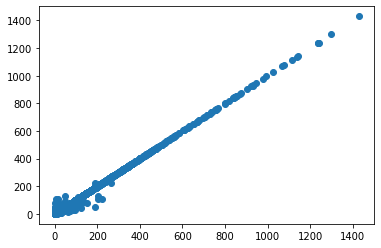

Test Error: 22.19


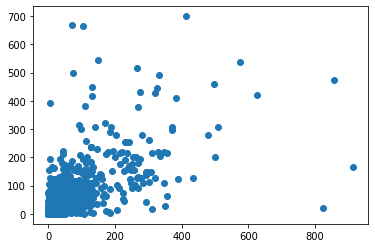

Fold #5
Train Error: 1.39


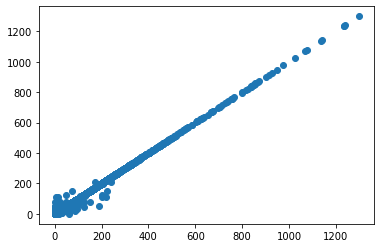

Test Error: 27.4


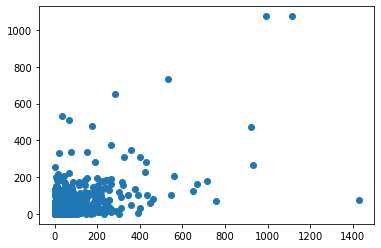

Fold #6
Train Error: 1.58


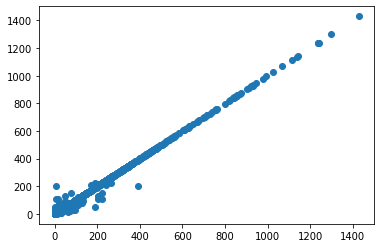

Test Error: 26.63


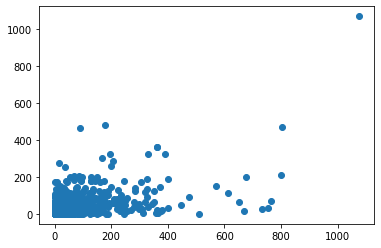

Fold #7
Train Error: 1.51


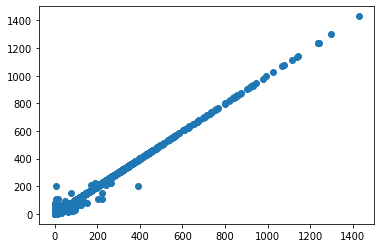

Test Error: 24.16


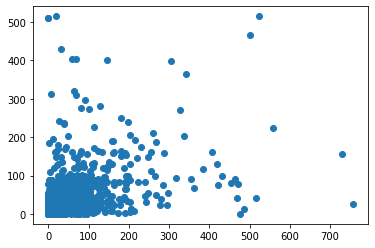

Fold #8
Train Error: 1.46


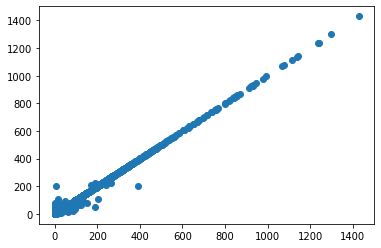

Test Error: 24.67


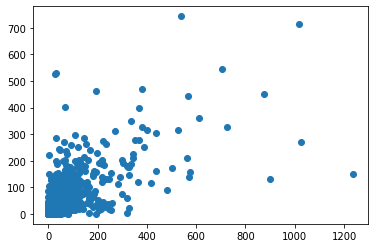

Fold #9
Train Error: 1.5


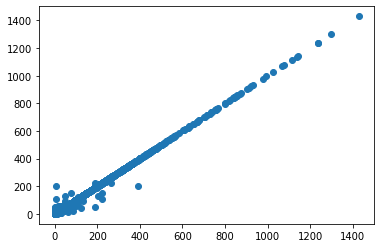

Test Error: 27.71


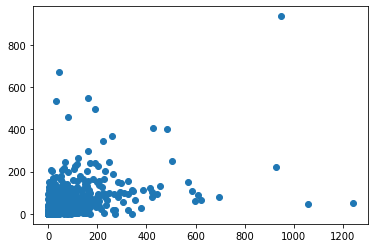

Fold #10
Train Error: 1.61


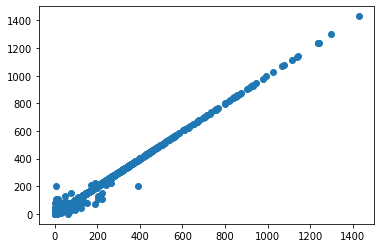

Test Error: 25.51


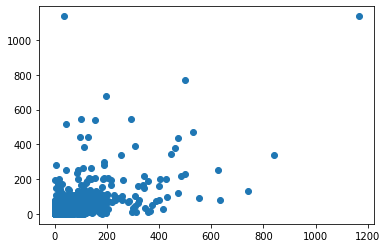

In [1350]:
knn = tuningPipeline(
    KNeighborsRegressor(
        n_neighbors=5,
        p=1,
        metric='minkowski',
        weights='distance',
        n_jobs=-1
    ),
    verbose=True
)

In [1351]:
report(knn)

Training Error: 1.52 (0.09 stdev) (5.92% CV)
Validation Error: 25.97 (1.91 stdev) (7.35% CV)


The KNN performed about as well as its baseline run, but was not significantly better than the random forest. Furthermore, the charts show signs of overfitting.

Fold #1
Binning 0.017 GB of training data: 0.128 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.016s
[2/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.016s
[3/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[4/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.021s
[5/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[6/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[7/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[8/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.013s
[9/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.017s
[10/1000] 1 tree, 5 leaves, max depth = 3, 

[87/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[88/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.014s
[89/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[90/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[91/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[92/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[93/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[94/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[95/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.011s
[96/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[97/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val lo

[175/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[176/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[177/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[178/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[179/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[180/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[181/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.013s
[182/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[183/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[184/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[185/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[263/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[264/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[265/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[266/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[267/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[268/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[269/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[270/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[271/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[272/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[273/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[351/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[352/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[353/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[354/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[355/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[356/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[357/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[358/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[359/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[360/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[361/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[439/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[440/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[441/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[442/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[443/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[444/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[445/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[446/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.011s
[447/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[448/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[449/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[527/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[528/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[529/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.010s
[530/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[531/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[532/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[533/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[534/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[535/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[536/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[537/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[615/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[616/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[617/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[618/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[619/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[620/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[621/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[622/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.010s
[623/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[624/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[625/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[702/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[703/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[704/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[705/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[706/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[707/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[708/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[709/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[710/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[711/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[712/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[790/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[791/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[792/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[793/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[794/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[795/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[796/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[797/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[798/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[799/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[800/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[878/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[879/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[880/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[881/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[882/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[883/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[884/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[885/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[886/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.012s
[887/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[888/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[966/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[967/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[968/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[969/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[970/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.010s
[971/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[972/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[973/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[974/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[975/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[976/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

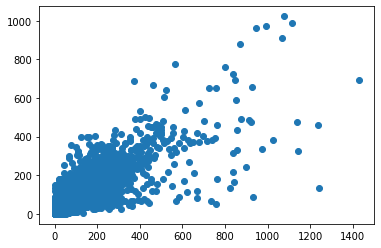

Test Error: 20.96


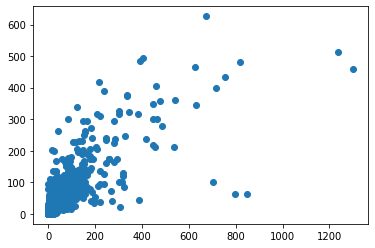

Fold #2
Binning 0.017 GB of training data: 0.125 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[2/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[3/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[4/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[5/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[6/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[7/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[8/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[9/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[10/1000] 1 tree, 5 leaves, max depth = 3, 

[88/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[89/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[90/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[91/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[92/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[93/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[94/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[95/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[96/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[97/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[98/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val lo

[176/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.018s
[177/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[178/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.011s
[179/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.022s
[180/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[181/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[182/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[183/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[184/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[185/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[186/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[264/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[265/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[266/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[267/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[268/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[269/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[270/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[271/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[272/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[273/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.012s
[274/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[351/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[352/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[353/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[354/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[355/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[356/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[357/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[358/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[359/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[360/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[361/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[439/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[440/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[441/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[442/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[443/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[444/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[445/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.013s
[446/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[447/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[448/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[449/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[527/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[528/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[529/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[530/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[531/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.013s
[532/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[533/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[534/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[535/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[536/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[537/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[615/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[616/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[617/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[618/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.013s
[619/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[620/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[621/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[622/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[623/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[624/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[625/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[702/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[703/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[704/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[705/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[706/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[707/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[708/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[709/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.013s
[710/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[711/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[712/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[789/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[790/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[791/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[792/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[793/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[794/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[795/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[796/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.013s
[797/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[798/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[799/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[877/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[878/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[879/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[880/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[881/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[882/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[883/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[884/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[885/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[886/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[887/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[965/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[966/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[967/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.011s
[968/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[969/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[970/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[971/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[972/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[973/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[974/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[975/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

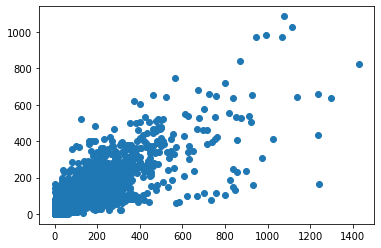

Test Error: 19.78


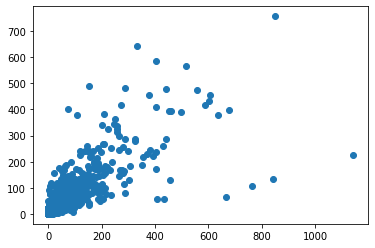

Fold #3
Binning 0.017 GB of training data: 0.124 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[2/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[3/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[4/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[5/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[6/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[7/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[8/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[9/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[10/1000] 1 tree, 5 leaves, max depth = 3, 

[88/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[89/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[90/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[91/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[92/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[93/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[94/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.012s
[95/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[96/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[97/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[98/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val lo

[175/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[176/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[177/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[178/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[179/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[180/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[181/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[182/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[183/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[184/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[185/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[263/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[264/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[265/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[266/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[267/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[268/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[269/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[270/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[271/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[272/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[273/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[351/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[352/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[353/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[354/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[355/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[356/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[357/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[358/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[359/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[360/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[361/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[438/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[439/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[440/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[441/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[442/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[443/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[444/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[445/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[446/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[447/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[448/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[526/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[527/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[528/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[529/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[530/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[531/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[532/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[533/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[534/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[535/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[536/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[614/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[615/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[616/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[617/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[618/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[619/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[620/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[621/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[622/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[623/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[624/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[702/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[703/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[704/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[705/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[706/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[707/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[708/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[709/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[710/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[711/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[712/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[790/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[791/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[792/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[793/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[794/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[795/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[796/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[797/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[798/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[799/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[800/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[877/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[878/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[879/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[880/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[881/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[882/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[883/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[884/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[885/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[886/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[887/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

Train Error: 16.55


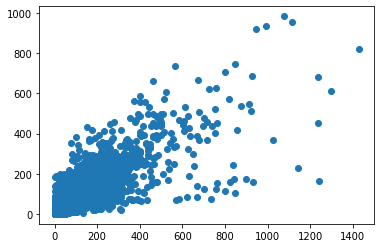

Test Error: 19.09


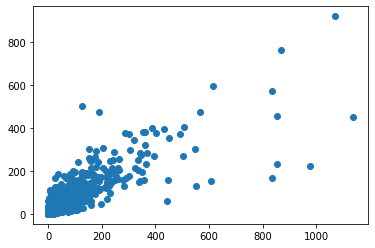

Fold #4
Binning 0.017 GB of training data: 0.123 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[2/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[3/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[4/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[5/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[6/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[7/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[8/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[9/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[10/1000] 1 tree, 5 leaves, max depth = 3, 

[88/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[89/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[90/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[91/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[92/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[93/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[94/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[95/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[96/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[97/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[98/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val lo

[176/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[177/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[178/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[179/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[180/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[181/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[182/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[183/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[184/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[185/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[186/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[264/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[265/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[266/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[267/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.012s
[268/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[269/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.010s
[270/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[271/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[272/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[273/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[274/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[352/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[353/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[354/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.012s
[355/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[356/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.010s
[357/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[358/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[359/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[360/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[361/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[362/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[440/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[441/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[442/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[443/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[444/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[445/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[446/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[447/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[448/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[449/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[450/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[527/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[528/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[529/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[530/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[531/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[532/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[533/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[534/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[535/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[536/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[537/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[614/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[615/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[616/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[617/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[618/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[619/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[620/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.011s
[621/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[622/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[623/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[624/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[702/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[703/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[704/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[705/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[706/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[707/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[708/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[709/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[710/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[711/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[712/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[790/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[791/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[792/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.011s
[793/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[794/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[795/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[796/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[797/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[798/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[799/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[800/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[878/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[879/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[880/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[881/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[882/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[883/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[884/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[885/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[886/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[887/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[888/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[966/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[967/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[968/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[969/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[970/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[971/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[972/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[973/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[974/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[975/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[976/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

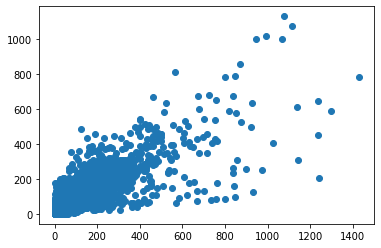

Test Error: 16.8


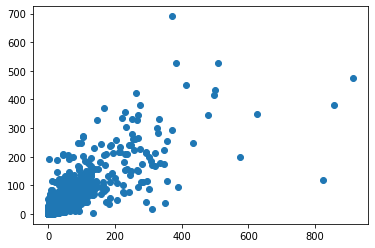

Fold #5
Binning 0.017 GB of training data: 0.123 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[2/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[3/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[4/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[5/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[6/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[7/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[8/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[9/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[10/1000] 1 tree, 5 leaves, max depth = 3, 

[87/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[88/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[89/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[90/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[91/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[92/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[93/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[94/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[95/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[96/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[97/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val lo

[175/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[176/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[177/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[178/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[179/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[180/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[181/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[182/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[183/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[184/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[185/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[263/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[264/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[265/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[266/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.014s
[267/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[268/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[269/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[270/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[271/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[272/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[273/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[350/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[351/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.010s
[352/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[353/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[354/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[355/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[356/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[357/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[358/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[359/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[360/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[438/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[439/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[440/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[441/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[442/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.010s
[443/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[444/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[445/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[446/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[447/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[448/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[526/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[527/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[528/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[529/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[530/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[531/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[532/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[533/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[534/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[535/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[536/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[614/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[615/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[616/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[617/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[618/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[619/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[620/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.010s
[621/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[622/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[623/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[624/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[702/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[703/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[704/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[705/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[706/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[707/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[708/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[709/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.013s
[710/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[711/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[712/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[790/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[791/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[792/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[793/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[794/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[795/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.013s
[796/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[797/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[798/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[799/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[800/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[878/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[879/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[880/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[881/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[882/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[883/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[884/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[885/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
Fit 885 trees in 5.235 s, (4425 total leaves)
Time spent computing histograms: 0.272s
Time spent finding best splits:  0.097s
Time spent applying splits:      0.294s
Time spent predicting:           0.153s
Train Error: 16.83


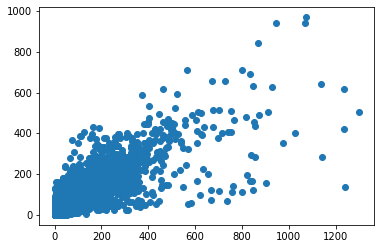

Test Error: 18.36


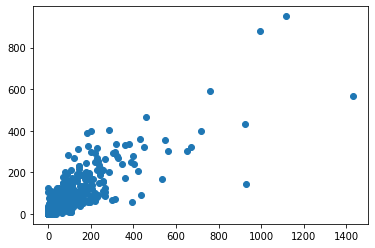

Fold #6
Binning 0.017 GB of training data: 0.123 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[2/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[3/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[4/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[5/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[6/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[7/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[8/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[9/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[10/1000] 1 tree, 5 leaves, max depth = 3, 

[88/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[89/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[90/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[91/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[92/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[93/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[94/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[95/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[96/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[97/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[98/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val lo

[176/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[177/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[178/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[179/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[180/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[181/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[182/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[183/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[184/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[185/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[186/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[264/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[265/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[266/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.014s
[267/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[268/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[269/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[270/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[271/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[272/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[273/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[274/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[352/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[353/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[354/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[355/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[356/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[357/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[358/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[359/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[360/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[361/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[362/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[440/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[441/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[442/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[443/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.011s
[444/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[445/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.011s
[446/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[447/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[448/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[449/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[450/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[528/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[529/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[530/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[531/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.011s
[532/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[533/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[534/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[535/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[536/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[537/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[538/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[616/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[617/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[618/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[619/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[620/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[621/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[622/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[623/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[624/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[625/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[626/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[704/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[705/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[706/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[707/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[708/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[709/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[710/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[711/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[712/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[713/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[714/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[792/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[793/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[794/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[795/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[796/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[797/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[798/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[799/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[800/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[801/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[802/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[880/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[881/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[882/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[883/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[884/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[885/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[886/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[887/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[888/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[889/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[890/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

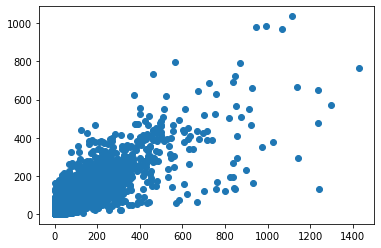

Test Error: 17.44


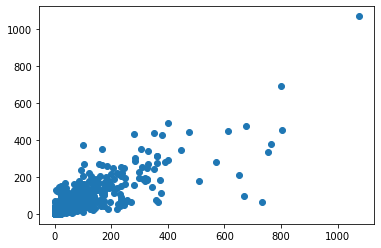

Fold #7
Binning 0.017 GB of training data: 0.125 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[2/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[3/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[4/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[5/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[6/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[7/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[8/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[9/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[10/1000] 1 tree, 5 leaves, max depth = 3, 

[87/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[88/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[89/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[90/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[91/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[92/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[93/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[94/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[95/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[96/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[97/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val lo

[175/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[176/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[177/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[178/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[179/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.012s
[180/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[181/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[182/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[183/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[184/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[185/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[263/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[264/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[265/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[266/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[267/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[268/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[269/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[270/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[271/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[272/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[273/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[351/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[352/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[353/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[354/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.011s
[355/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[356/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[357/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[358/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[359/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[360/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[361/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[439/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[440/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[441/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[442/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[443/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[444/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[445/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[446/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[447/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[448/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[449/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[527/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[528/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[529/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.012s
[530/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[531/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[532/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[533/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[534/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[535/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[536/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[537/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

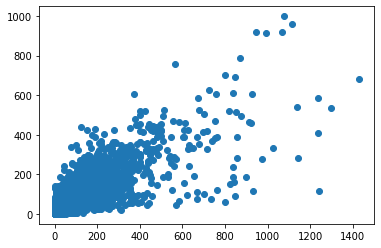

Test Error: 15.25


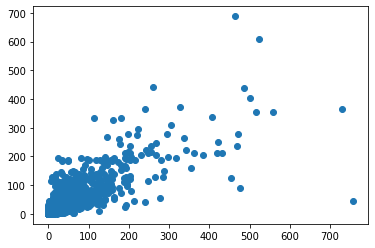

Fold #8
Binning 0.017 GB of training data: 0.124 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[2/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[3/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[4/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[5/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[6/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[7/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[8/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[9/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[10/1000] 1 tree, 5 leaves, max depth = 3, 

[88/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[89/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[90/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[91/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[92/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[93/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[94/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[95/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[96/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[97/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[98/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val lo

[176/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[177/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[178/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[179/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[180/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[181/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[182/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[183/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[184/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[185/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[186/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[264/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[265/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[266/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[267/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[268/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.013s
[269/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[270/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[271/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[272/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[273/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[274/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[352/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[353/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[354/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[355/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[356/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[357/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[358/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[359/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[360/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[361/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[362/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[440/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[441/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[442/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.012s
[443/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[444/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[445/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[446/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[447/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[448/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[449/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[450/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[528/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[529/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.010s
[530/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[531/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[532/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[533/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[534/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[535/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[536/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[537/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[538/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[616/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[617/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[618/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[619/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[620/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[621/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[622/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[623/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[624/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[625/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[626/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

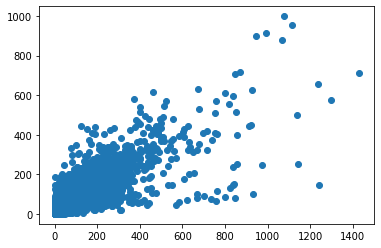

Test Error: 20.68


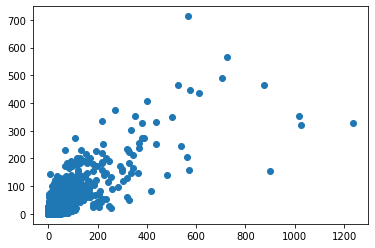

Fold #9
Binning 0.017 GB of training data: 0.122 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[2/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[3/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[4/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[5/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[6/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[7/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[8/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[9/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[10/1000] 1 tree, 5 leaves, max depth = 3, 

[88/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[89/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[90/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[91/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[92/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[93/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[94/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[95/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[96/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[97/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[98/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val lo

[176/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[177/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[178/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[179/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[180/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[181/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[182/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[183/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[184/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[185/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[186/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[264/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[265/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[266/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[267/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[268/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[269/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[270/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[271/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[272/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[273/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[274/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[352/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[353/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[354/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[355/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[356/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.016s
[357/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[358/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[359/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[360/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[361/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[362/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[439/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[440/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[441/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[442/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[443/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.010s
[444/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[445/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[446/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[447/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[448/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[449/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[527/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[528/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[529/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[530/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[531/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[532/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[533/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[534/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[535/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[536/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[537/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[615/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[616/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.015s
[617/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[618/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.010s
[619/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[620/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[621/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[622/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[623/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[624/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[625/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[703/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[704/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[705/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[706/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[707/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[708/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[709/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[710/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[711/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[712/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[713/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[791/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.011s
[792/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[793/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.010s
[794/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[795/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[796/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[797/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[798/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[799/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[800/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[801/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[879/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.014s
[880/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[881/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[882/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[883/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[884/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[885/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[886/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[887/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[888/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[889/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[967/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[968/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[969/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[970/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[971/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[972/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[973/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.009s
[974/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[975/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[976/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[977/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

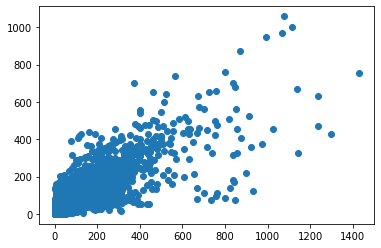

Test Error: 20.66


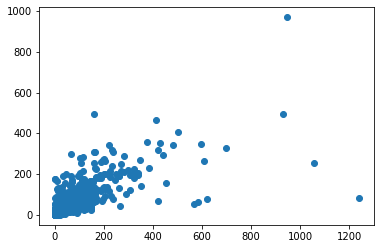

Fold #10
Binning 0.017 GB of training data: 0.124 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[2/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[3/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[4/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[5/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[6/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[7/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[8/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[9/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[10/1000] 1 tree, 5 leaves, max depth = 3,

[88/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[89/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[90/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[91/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.013s
[92/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[93/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[94/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[95/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[96/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[97/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[98/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val lo

[176/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[177/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[178/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[179/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[180/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[181/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[182/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.009s
[183/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[184/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[185/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[186/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[264/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[265/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.006s
[266/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[267/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[268/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[269/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[270/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[271/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[272/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[273/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.010s
[274/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[352/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[353/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[354/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[355/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[356/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[357/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[358/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[359/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[360/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[361/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[362/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[440/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[441/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[442/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[443/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.010s
[444/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[445/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.010s
[446/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[447/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[448/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[449/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[450/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[528/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[529/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[530/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[531/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[532/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[533/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[534/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[535/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[536/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[537/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[538/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[616/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[617/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[618/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[619/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[620/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[621/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[622/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[623/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[624/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.010s
[625/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[626/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[704/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[705/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[706/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[707/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[708/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[709/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[710/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[711/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[712/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[713/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[714/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00

[792/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[793/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[794/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[795/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.007s
[796/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[797/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[798/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[799/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[800/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[801/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[802/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[879/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[880/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[881/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[882/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.012s
[883/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[884/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.011s
[885/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[886/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.006s
[887/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.008s
[888/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[889/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

[967/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[968/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[969/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.005s
[970/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[971/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.007s
[972/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[973/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.004s
[974/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.008s
[975/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00000, val loss: 0.00000, in 0.004s
[976/1000] 1 tree, 5 leaves, max depth = 3, train loss: 0.00000, val loss: 0.00000, in 0.005s
[977/1000] 1 tree, 5 leaves, max depth = 4, train loss: 0.00

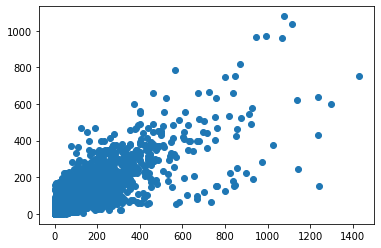

Test Error: 15.85


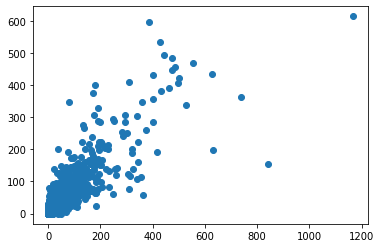

In [1352]:
boost = tuningPipeline(
    HistGradientBoostingRegressor(
        learning_rate=0.01,
        max_depth=5,
        max_leaf_nodes=5,
        random_state=G_RANDOM_SEED,
        max_iter=1000,
        tol=1e-100,
        verbose=1
    ),
    verbose=True
)

In [1353]:
report(boost)

Training Error: 16.83 (0.38 stdev) (2.26% CV)
Validation Error: 18.49 (2.08 stdev) (11.25% CV)


The histogram boosting model performed the best, likely due to it being better at finding clusters or "strings" than the Random Forest. 

### Aggregate Production Models

Fold #1
Train Error: 15.24


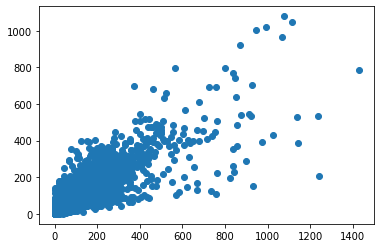

Test Error: 20.91


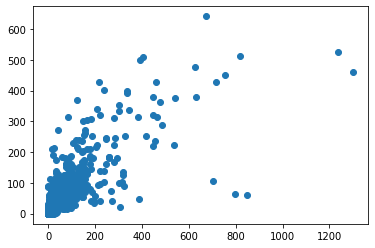

Fold #2
Train Error: 16.0


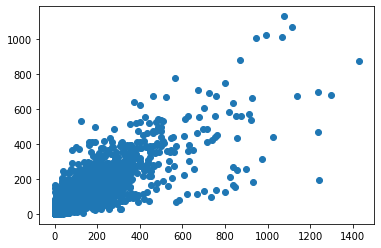

Test Error: 19.75


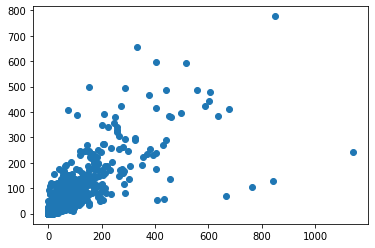

Fold #3
Train Error: 16.5


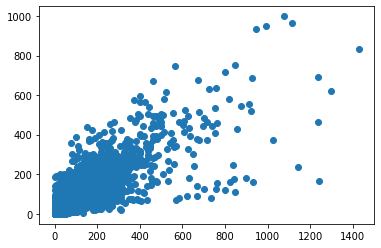

Test Error: 19.07


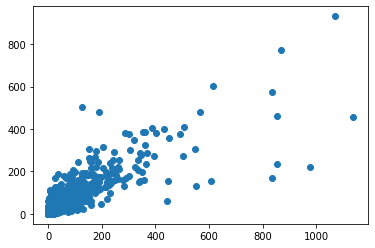

Fold #4
Train Error: 15.46


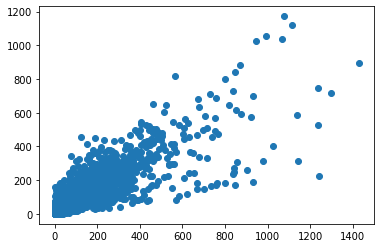

Test Error: 16.97


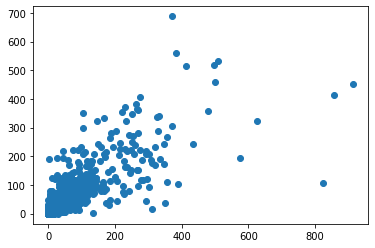

Fold #5
Train Error: 16.42


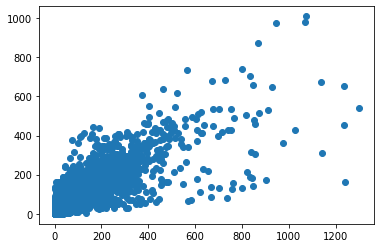

Test Error: 18.15


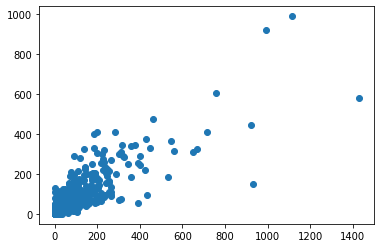

Fold #6
Train Error: 16.31


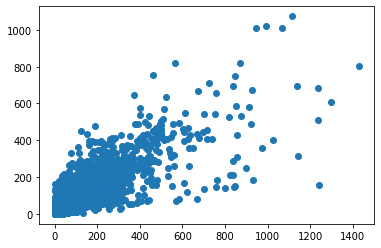

Test Error: 17.36


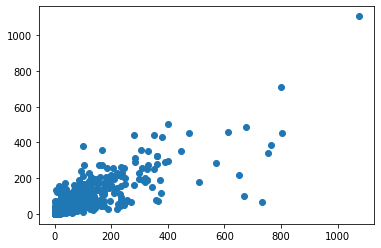

Fold #7
Train Error: 17.23


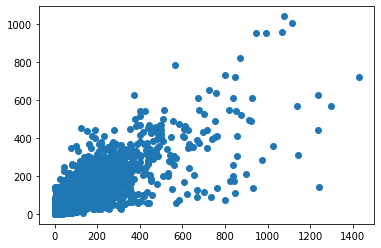

Test Error: 15.27


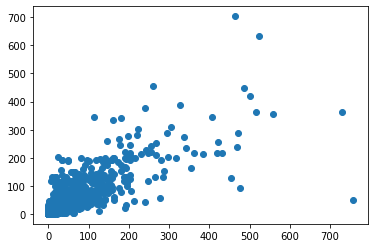

Fold #8
Train Error: 16.08


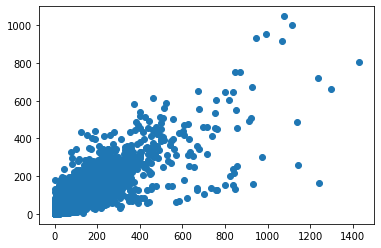

Test Error: 20.63


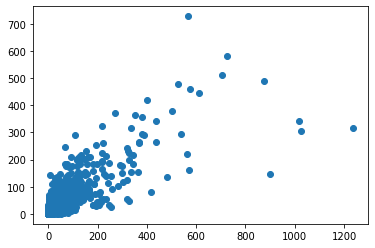

Fold #9
Train Error: 16.21


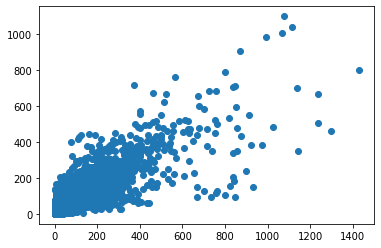

Test Error: 20.63


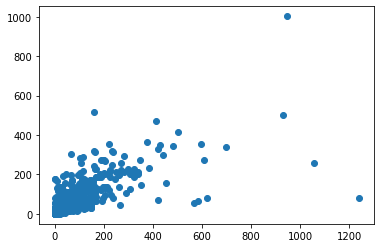

Fold #10
Train Error: 16.58


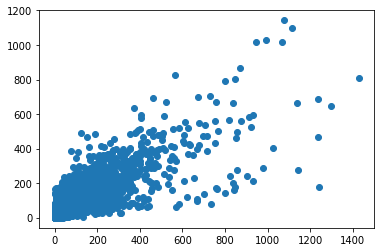

Test Error: 15.77


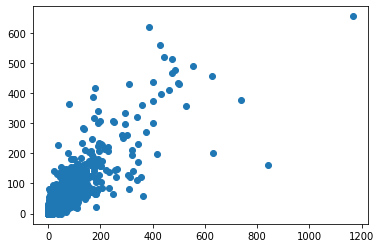

In [1354]:
stack = tuningPipeline(
    StackingRegressor(
        estimators=[
            ('rf', regr['models'][0]),
            ('knn', knn['models'][0]),
            ('boost', boost['models'][0])
        ],
        final_estimator=LinearRegression(
            n_jobs=-1
        ),
        cv=10,
        n_jobs=-1,
        verbose=1
    ),
    verbose=True
)

In [1355]:
report(stack)

Training Error: 16.2 (0.57 stdev) (3.52% CV)
Validation Error: 18.45 (2.07 stdev) (11.22% CV)


In [1356]:
pd.DataFrame(
    np.round(
        stack['models'][0].final_estimator_.coef_.reshape((1,3)),
        4
    ),
    columns=[
        'Random Forest',
        'KNN',
        'Boosted Tree'
    ],
    index=['Regression Coefficients']
)

Random Forest     KNN  Boosted Tree
Regression Coefficients         -0.063  0.0196        1.0415

Stacking the regressors only improved the validation performance slightly. However, there was an overall better fit on the training data, which would make the stacked regressor slightly better to use than the regular, boosted tree.

As shown, the boosted tree comprised the majority of the final prediction, with random forest and KNN having almost no impact. The slight improvement in performance could even be replicated with more exacting hyperparameter search on the boosted tree. Overall, stacking had a minimal impact.

### Train Final Model

The entire dataset (including validation) is used to train this model. 

In [1372]:
def finalPipeline(
    model,
    verbose=False
):
    # Define starting data for pipeline
    X = DATA_TRAIN_AND_VALID_X_ENCODED
    y = DATA_TRAIN_AND_VALID_Y
    
    returnDict = {
        'model': None,
        'error': [],
        'pred': None
    }

    X_train = DATA_TRAIN_AND_VALID_X_ENCODED
    y_train = DATA_TRAIN_AND_VALID_Y
    X_test = DATA_TEST_X_ENCODED

    # Split numerical and one-hot-encoded features
    X_NOM = X_train[[
        col for col in X_train.columns
        if any(
            substring in col
            for substring in G_NOM_SUBSTR
        )
    ]]
    X_NUM = X_train[[
        col for col in X_train.columns
        if not any(
            substring in col
            for substring in G_NOM_SUBSTR
        )
    ]]

    # The below pipeline steps are copied from above

    # Feature selection

    # Handle outliers
    maxFeatures = X_NUM.columns.size

    X_NUM_CLEANED_OUTLIERS = X_NUM[
        X_NUM[
            (X_NUM < X_NUM.quantile(0.75)) &
            (X_NUM > X_NUM.quantile(0.25))
        ].sum(
            axis=1
        ) > maxFeatures
    ]

    # also apply to target feature
    y_CLEANED_OUTLIERS = y_train[
        X_NUM[
            (X_NUM < X_NUM.quantile(0.75)) &
            (X_NUM > X_NUM.quantile(0.25))
        ].sum(
            axis=1
        ) > maxFeatures
    ]

    # Feature engineering
    if 'CC3MinusCC4_CC6' not in X_NUM_CLEANED_OUTLIERS:
        X_NUM_CLEANED_OUTLIERS.insert(
            numCols,
            'CC3MinusCC4_CC6',
            X_NUM_CLEANED_OUTLIERS.CommentsFirst24H_CC4 - X_NUM_CLEANED_OUTLIERS.CommentsLast48to24H_CC3
        )
    if 'CC2MinusCC4_CC7' not in X_NUM_CLEANED_OUTLIERS:
        X_NUM_CLEANED_OUTLIERS.insert(
            numCols,
            'CC2MinusCC4_CC7',
            X_NUM_CLEANED_OUTLIERS.CommentsFirst24H_CC4 - X_NUM_CLEANED_OUTLIERS.CommentsLast24H_CC2
        )

    if 'CC3MinusCC4_CC6' not in X_test:
        X_test.insert(
            numCols,
            'CC3MinusCC4_CC6',
            X_test.CommentsFirst24H_CC4 - X_test.CommentsLast48to24H_CC3
        )
    if 'CC2MinusCC4_CC7' not in X_test:
        X_test.insert(
            numCols,
            'CC2MinusCC4_CC7',
            X_test.CommentsFirst24H_CC4 - X_test.CommentsLast24H_CC2
        )
    # throws false positive SettingWithCopyWarning

    # Feature selection
    # According to above note in markdown cell, uses same columns instead of applying the pipeline again
    # This is to guarantee the same features are used in all folds
    selectedNums = [col for col in selectedFeatures if col in X_NUM_CLEANED_OUTLIERS]
    selectedNoms = [col for col in selectedFeatures if col in X_NOM]
    X_NUM_SELECTED = X_NUM_CLEANED_OUTLIERS[selectedNums]
    X_NOM_SELECTED = X_NUM_CLEANED_OUTLIERS[selectedNoms]
    X_test_SELECTED = X_test[selectedFeatures]

    # Normalize data
    skewTransformsFinal = []
    def transformSkewFinal(col, undo=False):
        if undo:
            currentTransform = [
                transform for transform in skewTransformsFinal
                if transform['Series'] == col.name
            ][0]
            for _ in range(currentTransform['exp']):
                col = np.log(col + 1) * 100000000
            for _ in range(currentTransform['log']):
                col = np.exp(col / 100000000) - 1
        else:
            skew = col.skew()
            currentTransform = {
                'Series': col.name,
                'exp': 0,
                'log': 0
            }
            while skew > 1.5 or skew < -1.5:
                if skew > 1.5:
                    col = np.exp(col / 100000000) - 1 # prevent inf
                    currentTransform['exp'] += 1
                elif skew < -1.5:
                    col = np.log(col + 1) * 100000000
                    currentTransform['log'] += 1
                skew = col.skew()
            skewTransformsFinal.append(currentTransform)
        return(col)

    X_NUM_SKEW = X_NUM_SELECTED.apply(
        transformSkewFinal,
        axis=0
    )
    y_CLEANED_SKEW = transformSkewFinal(y_CLEANED_OUTLIERS)

    # Aggregate final train set
    X_FINAL = X_NUM_SKEW.join(X_NOM_SELECTED)
    y_FINAL = y_CLEANED_SKEW

    #Normalize validation set
    def reapplyTransformSkewFinal(col):
        if any(obj['Series'] == col.name for obj in skewTransformsFinal):
            skewTransformFinal = [
                obj for obj in skewTransformsFinal
                if obj['Series'] == col.name
            ]
            transformedCol = col
            for i in range(skewTransformFinal[0]['exp']):
                transformedCol = np.exp(transformedCol / 100000000) - 1
            for i in range(skewTransformFinal[0]['log']):
                transformedCol = np.log(transformedCol + 1) * 100000000
            return(transformedCol)
        return(col)

    def cleanFinal(df, undo=False):
        dfClean = df.apply(reapplyTransformSkewFinal)
        return(dfClean)

    X_test_TRANSFORMED = cleanFinal(X_test_SELECTED[X_FINAL.columns])

    ## Train & run model
    def scoreFinal(truth, pred, trainOrTest='Test', verbose=False):
        error = round(mean_squared_error(truth, pred, squared=False), 2)
        if verbose:
            print(trainOrTest, 'Error:', error)
        return(error)

    def FinalPipeline(
        model,
        X_train,
        y_train,
        X_test,
        y_train_untransformed,
        verbose=False
    ):
        model.fit(X_train, y_train)
        train_pred = pd.Series(
            model.predict(X_train),
            name='CommentsNumber',
            index=X_train.index
        )
        pred = pd.Series(
            model.predict(X_test),
            name='CommentsNumber',
            index=X_test.index
        )
        normalizedTrainPred = transformSkew(train_pred, undo=True)
        errorTrain = scoreFinal(
            y_train_untransformed,
            normalizedTrainPred,
            'Train',
            verbose
        )
        plt.scatter(y_train_untransformed, normalizedTrainPred)
        plt.show()
        normalizedTestPred = transformSkew(pred, undo=True)
        returnDict['error'].append(errorTrain)
        returnDict['pred'] = normalizedTestPred
        return(model)

    trainedModel = FinalPipeline(
        model,
        X_FINAL,
        y_FINAL,
        X_test_TRANSFORMED,
        y_CLEANED_OUTLIERS,
        verbose
    )
    returnDict['models'] = trainedModel

    return(returnDict)

Train Error: 17.12


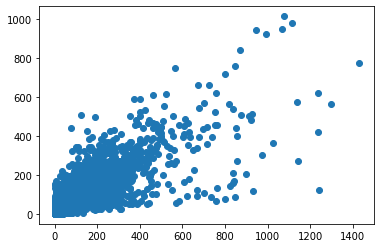

In [1374]:
model = finalPipeline(
    StackingRegressor(
        estimators=[
            ('rf', regr['models'][0]),
            ('knn', knn['models'][0]),
            ('boost', boost['models'][0])
        ],
        final_estimator=LinearRegression(
            n_jobs=-1
        ),
        cv=10,
        n_jobs=-1,
        verbose=1
    ),
    verbose=True
)

In [1380]:
output = pd.DataFrame({
    'ID': DATA_TEST_RAW.ID,
    'CommentsNumber': np.round(model['pred'], 0).astype(int)
})
output

ID  CommentsNumber
0      130000              11
1      130001               2
2      130002             282
3      130003               7
4      130004             107
...       ...             ...
69026  199026             298
69027  199027             193
69028  199028             171
69029  199029              33
69030  199030              42

[69031 rows x 2 columns]

In [1381]:
output.to_csv(
    './C2T2_Test_Labeled.csv',
    sep=',',
    index=False
)